In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, DistanceMetric
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc
from sklearn.covariance import EllipticEnvelope 
#
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
import gower
from scipy.spatial.distance import hamming

# Filter all warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# # list of 8 applications in dataset
classes = ['Dropcam', 'HP Printer', 'Netatmo Welcome', 'Withings Smart Baby Monitor', 'Netatmo weather station',\
           'Smart Things', 'Amazon Echo', 'Samsung SmartCam','TP-Link Day Night Cloud camera', 'Triby Speaker',\
              'Belkin Wemo switch', 'TP-Link Smart plug', 'PIX-STAR Photo-frame','Belkin wemo motion sensor',\
                     'Samsung Galaxy Tab', 'NEST Protect smoke alarm', 'Withings Smart scale', 'IPhone',\
                            'MacBook', 'Withings Aura smart sleep sensor','Light Bulbs LiFX Smart Bulb',\
                            'Blipcare Blood Pressure meter','iHome', 'Insteon Camera', 'Android Phone', 'Laptop']
classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports

"""
Function to calculate the score of the model
"""
def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def get_x_y_flow_binary(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

"""
Function to calculate the score of the model in terms of Flow-Level metric
"""
def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    ####
    expanded_y_true_Dropcam = []
    expanded_y_pred_Dropcam = []
    #
    expanded_weights_Dropcam = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
                 
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL, expanded_y_true, expanded_y_pred, expanded_weights

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [6]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [7]:
#### PCFI - Per Class Feature Importance ####
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()

def f_entropy(v):
    return sps.entropy(pk=v)

def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        # print('NODE PRED:', node_pred)
        leaves_class_index = node_pred[is_leaves]
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            # print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]
                
                # print(leaves_class_index, current_values_class)
                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        # print(tree_importances.shape)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])
        # print(importance_matrix)

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

## WITHOUT LIMITATION

#### N=3 RF(23, 32,15) - Generate the chosen model

In [8]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
###########
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)

###########
#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########

all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)

# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)
#
train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)
#
train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])
#
test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))
#
train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)
#
train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)
#
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

Num Labels:  24


In [9]:
## The model (the best) chosen for analysis
depth = 23
n_tree = 32
no_feats = 15
leaf = 500
# feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
feats = ['tcp.window_size_value', 'ip.len', 'udp.length', 'dstport', 'ip.ttl', 'tcp.hdr_len', 'srcport', 'Packet Length Total', 'Packet Length Mean', 'Max Packet Length', 'tcp.flags.rst', 'Flow IAT Max', 'Flow IAT Mean', 'Flow Duration', 'Flow IAT Min']
#
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL, expanded_y_true, expanded_y_pred, expanded_weights  = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)
0.7923829498103626 0.9081743142574276 0.9065605200052853


#### Confusion Matrix

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
#
# plt.figure(figsize=(50,50))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# ax.set_xticklabels(classes, rotation=90)
#
# df_cols = ['Class_Name'] + classes
cm_df = pd.DataFrame(columns=classes)

for i in range(0, len(classes)):
    true_label = cm[i]
    cm_df.loc[len(cm_df.index)] = true_label
cm_df.insert(loc=0, column='Class_Name', value=classes)

In [154]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# #
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# fig, ax = plt.subplots(figsize=(30,30))
# disp.plot(ax=ax)
# ax.set_xticklabels(classes, rotation=90)

#### Order classes in terms of its scores and PLOT F1-score Per Class

In [10]:
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []
support_values = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
        support_values.append(cl_report_FL[c_name]['support'])

classes_.append('IPhone')
score_per_class.append(0)
support_values.append(0)
classes_.append('Blipcare Blood Pressure meter')
score_per_class.append(0.001)
support_values.append(0)
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class, 'support': support_values})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

In [11]:
cl_report_FL

{'Laptop': {'precision': 0.9718742870348502,
  'recall': 0.9117356017875112,
  'f1-score': 0.9408449097764243,
  'support': 11484.000000007463},
 'Insteon Camera': {'precision': 0.8862300129752665,
  'recall': 0.9967082446122089,
  'f1-score': 0.9382280666886891,
  'support': 6887.999999999669},
 'Samsung SmartCam': {'precision': 0.9768491657545977,
  'recall': 0.9780426157263765,
  'f1-score': 0.9774455264433817,
  'support': 13334.000000004085},
 'Amazon Echo': {'precision': 0.9720873301499645,
  'recall': 0.9616541005851617,
  'f1-score': 0.9668425698571494,
  'support': 4649.0},
 'Samsung Galaxy Tab': {'precision': 0.9022834072332899,
  'recall': 0.8188869800328156,
  'f1-score': 0.8585647765606759,
  'support': 7961.999999998589},
 'Belkin wemo motion sensor': {'precision': 0.9582867324150853,
  'recall': 0.9605670923232106,
  'f1-score': 0.9594255573828422,
  'support': 3281.9999999995284},
 'Netatmo Welcome': {'precision': 0.8861794502402178,
  'recall': 0.9045715353705123,
  'f

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


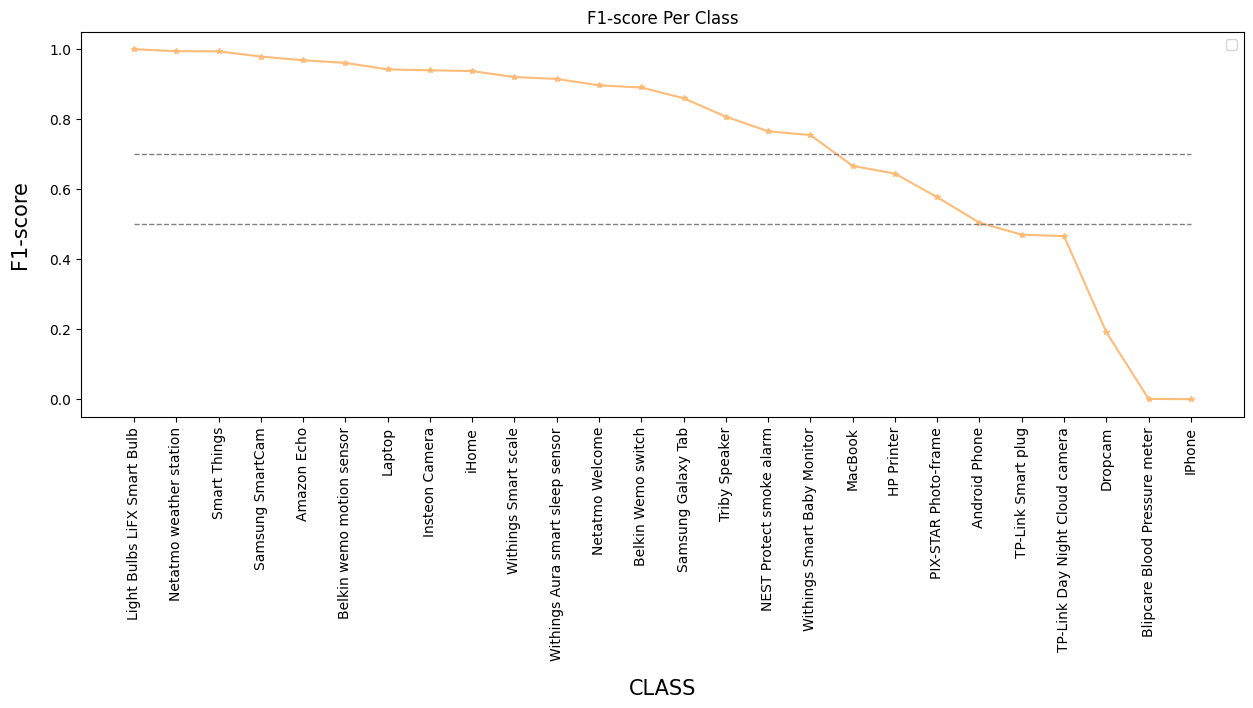

In [12]:
##### TEST
plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

# PCFI
#### Obtaining per-class feature importance

In [13]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)

In [14]:
### Matrix containing feature importances per feature-class pair
imp_mat = calcImportanceMatrix(rf_opt)

In [15]:
#### GET ordered classes and GET their features and feature importances in that order
imp_mat_ordered = []
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100
classes_ordered_main_model = score_per_class_df['class'].to_list()
class_scores_ordered = score_per_class_df['f1_score'].to_list()

for cl in classes_ordered_main_model:
    ind_of_class = classes.index(cl)
    imp_mat_ordered.append(imp_mat[ind_of_class])
    
## 2 classes which are not in TEST SET
# classes_ordered_main_model.append('IPhone')
# class_scores_ordered.append(0)
# imp_mat_ordered.append(imp_mat[classes.index('IPhone')])
# classes_ordered_main_model.append('Blipcare Blood Pressure meter')
# class_scores_ordered.append(1)
# imp_mat_ordered.append(imp_mat[classes.index('Blipcare Blood Pressure meter')])

In [16]:
len(classes_ordered_main_model)

26

In [17]:
feature_names = feats

# Outlier Detection

## Generate the data and detect outliers
#### With Plots

In [18]:
def take_derivative(class_name, data_dict, threshold):

    imp_list = data_dict[class_name]
    # print(imp_list)
    # Example CDF data
    x = np.arange(len(imp_list))
    y = imp_list

    # print(len(x))
    # print(len(y))

    # Compute the derivative
    dy_dx = np.gradient(y, x)
    print(dy_dx)
    selected_point_index = len(imp_list)-1
    selected_point = dy_dx[selected_point_index]
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0]
                selected_point = dy_dx[selected_point_index]
    print(selected_point, selected_point_index)
    #
    # Plot the CDF and its derivative
    plt.figure()
    
    plt.scatter(selected_point_index, imp_list[selected_point_index[0] ], color='red', s=45)
    plt.scatter(selected_point_index, dy_dx[selected_point_index[0] ], color='red', s=45)
    plt.plot(x, y, label='Cumulative Importance')
    plt.plot(x, dy_dx, label='Derivative of Cumulative Importance: ' + str(class_name))
    plt.xlabel('Classes')
    plt.ylabel('Importance')
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
max_exponent = 709
x_scores = []
y_importances = []
c_name = []
f_name = []
exp_values = []
normal_importances = []
for c in range(0, len(classes_ordered_main_model)):
    sum_exp_values = 0
    exp_values_per_class = []
    for f in range(0, len(feature_names)):
        c_name.append(classes_ordered_main_model[c])
        f_name.append(feature_names[f])
        x_scores.append(class_scores_ordered[c]/100)
        normal_importances.append(np.array(imp_mat_ordered)[c,f])
        try:
            if(np.array(imp_mat_ordered)[c,f] == 0):
                ### If the values is too big for math.exp
                y_importances.append(max_exponent)
                # print('first set')
            else:
                y_importances.append((1/(np.array(imp_mat_ordered)[c,f]*100)))
            exp_values.append(math.exp(y_importances[-1]))
        except:
            ### If the y_importance values is too big for math.exp
            y_importances[-1] = max_exponent
            exp_values.append(math.exp(y_importances[-1]))
            
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'y_importances': y_importances, 'exp_values': exp_values, 'normalized_exp': normalized_exp_values,  'density': density})
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values, 'log10_based_exp': log10_based,'normalized_exp': normalized_exp_values, 'sum_of_importances_log10':sum_of_importances_log10, 'inverse_exp': inverse_exp})
density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values})


density_df['FINAL'] = density_df['exp_values']/(density_df['normal_importances'])
density_df['normal_importances_100'] = density_df['normal_importances']*100
density_df['Feature'] = density_df['f_name'].replace(feature_names, range(len(feature_names)))
        

In [165]:
###### Get the results from other big model of least successful classes ######
# density_df = density_df[['c_name', 'f_name', 'x_scores', 'normal_importances']]
# L_classes = ['MacBook', 'HP Printer', 'PIX-STAR Photo-frame', 'Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera',\
#         'Dropcam', 'Blipcare Blood Pressure meter', 'IPhone']

# L_density_df = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness/density_df_big_model_exlClasses.csv')
# L_density_df = L_density_df[['c_name', 'x_scores', 'f_name', 'normal_importances']]
# #
# density_df = density_df[~density_df['c_name'].isin(L_classes)]
# #
# density_df = pd.concat((density_df, L_density_df))

In [166]:
prop_increase_dict = {}
cum_increase_dict = {}

In [20]:
### RELATIVE rate of change
def flag_outliers(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df['c_name'].unique()[0])
    # print('last_y', last_y)
    last_decrease = df.loc[0]['ccum_sum']-df.loc[1]['ccum_sum']
    # print('last decrease', last_decrease)
    decreases = [last_decrease]
    rel_decrease = [1]
    for index,row in df[2:].iterrows():
        curr_decrease = last_y - row['ccum_sum']
        # print('curr_decrease', curr_decrease)
        decreases.append(curr_decrease)
        rel_improvement =  last_decrease / curr_decrease
        rel_decrease.append(rel_improvement)
        if rel_improvement < th:
            cutoff.append(index)
        last_y = row['ccum_sum']
        last_decrease = curr_decrease
    # # PLOT
    # f, ax1 = plt.subplots()
    # ax1.plot(decreases, color='C0', label='decreases')
    # ax2 = ax1.twinx()
    # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    # ax1.set_title(df['c_name'].unique()[0])
    # plt.legend()
    # plt.show()
    if not cutoff:
        cutoff.append(index)
    # print(f'found cutoff: {cutoff[0]}!')
    df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [21]:
### RELATIVE rate of change
def flag_outliers_with_cost(df, col_name='normal_importances', th=0.5):
    df = df.assign(outlier=True)
    df = df.reset_index()
    # df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1)[::-1])[::-1]
    df['ccum_sum'] = np.cumsum(np.clip(df[col_name].to_numpy(),0.01,1))
    cutoff = []
    last_y = df.loc[1]['ccum_sum']
    # print(df)
    # print(df['c_name'].unique()[0])
    cost_values = [i/15 for i in range(1, 16)]
    total_gain_list = []
    ##
    for index,row in df.iterrows():
        ##
        # print('Feature NO: ', index, 'Total COST: ', cost_values[index], 'Total GAIN: ', row['ccum_sum'], 'DIFF: ', row['ccum_sum'] - cost_values[index])
        # print('Feature NO: ', count_feat, 'UI    :', math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        ### First Option
        total_gain =  row['ccum_sum'] - cost_values[index]
        ###
        ### Second Option
        # rel_improvement_cost = 0.45*rel_improvement - 0.55*(count_feat)/(15)
        ###
        ### Third Option
        # rel_improvement_cost = rel_improvement - 1.2*(count_feat)/(15)
        # print((count_feat-1)/(count_feat))
        
        # rel_improvement_cost =  rel_improvement - 0.8*((count_feat-1)/(count_feat))
        ###
        
        # rel_improvement_cost = rel_improvement*(math.log(row['ccum_sum']) - math.log(count_feat/(15)))
        total_gain_list.append(total_gain)
        # print('Rel_imp: ', rel_improvement, 'Rel_imp cost: ', rel_improvement_cost)
        # print(rel_improvement_cost)
        # if rel_improvement_cost <= 0:
        #     cutoff_cost.append(index)
        # count_feat = count_feat + 1
        ##
    ##
    # if not cutoff_cost:
    #     cutoff_cost.append(index)
    # print(f'found cutoff COST: {cutoff_cost[0]}!')
    ##
    ## Find the 
    total_gain_list = np.array(total_gain_list)
    index_cost = np.argmax(total_gain_list)
    
    # f, ax1 = plt.subplots()
    # ax1.plot(total_gain_list, color='C0', label='Total gain')
    # # ax2 = ax1.twinx()
    # # ax2.plot(rel_decrease, color='C1', label='rel_decreases')
    # ax1.set_title(df['c_name'].unique()[0])
    # plt.legend()
    # plt.show()
    
    df['outlier'].iloc[[i for i in range(index_cost+1)]]=False
    # print('Number of features to use: ', index_cost)
    # df['outlier'].iloc[[i for i in range(cutoff[0])]]=False
#     raise Exception
    return df.set_index('index', drop=True)

In [22]:
def flag_inliers(df, threshold=0.05):
    inliers=[]
    df = df.reset_index()
    last_increase = 0
    c_name = df['c_name'].unique()[0]
    prop_increase_dict[c_name] = []
    cum_increase_dict[c_name] = []
    cum_score = 0
    for index,row in df.iterrows():
        if index == 0:
            inliers.append(index)
            last_increase = row['normal_importances']
            cum_score = last_increase
            cum_increase_dict[c_name].append(cum_score)
        else:
            # if (row['normal_importances']/last_increase)<0.6:
            #     break
            # else:
            prop_increase_dict[c_name].append(row['normal_importances']/last_increase)
            last_increase = row['normal_importances']
            cum_score = cum_score + last_increase
            cum_increase_dict[c_name].append(cum_score)
            inliers.append(index)
            
    # Compute the derivative
    y = cum_increase_dict[c_name]
    x = np.arange(len(y))
    dy_dx = np.gradient(y, x)
    print(y)
    print(dy_dx)
    print('--')
    selected_point_index = len(y)-1
    for p_dvt in dy_dx:
        if p_dvt < threshold:
            if np.where(dy_dx == p_dvt)[0] < selected_point_index:
                selected_point_index = np.where(dy_dx == p_dvt)[0][0]
    # print(c_name, selected_point, selected_point_index)
    # print(c_name, len(inliers[:selected_point_index + 1]))
    
    df['outlier'].iloc[inliers[:selected_point_index]]=False
    return df.set_index('index', drop=True)

In [23]:
#### CALL flag_outliers per class - RELATIVE RATE of DECREASE
density_df = density_df.assign(outlier=True)
ord_param = 'normal_importances'
density_df = density_df.sort_values(by=ord_param,ascending=False).groupby('c_name', group_keys=False).apply(flag_outliers_with_cost, col_name=ord_param, th=0.65)
#
density_inliers_df = density_df[density_df['outlier']==False]

In [24]:
len(density_inliers_df)

135

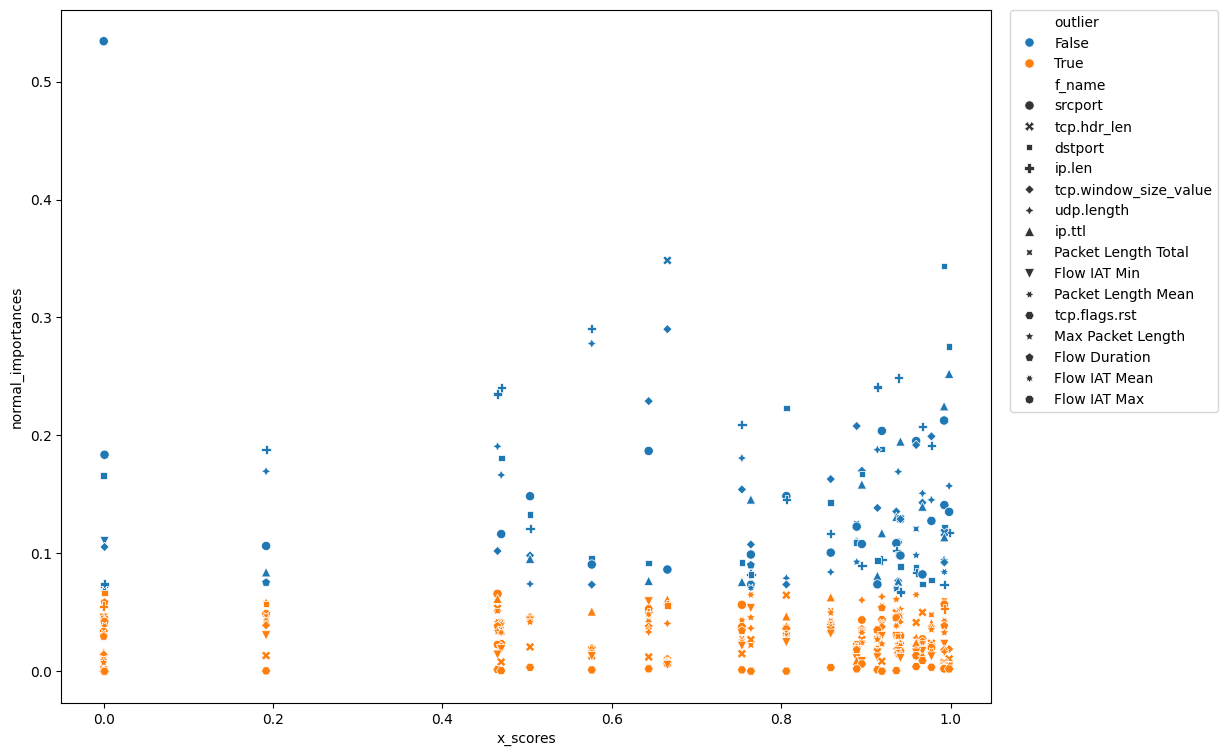

In [175]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_df, x='x_scores', y='normal_importances', ax=ax, hue='outlier', style="f_name", s=45)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.85, 1)
plt.show()

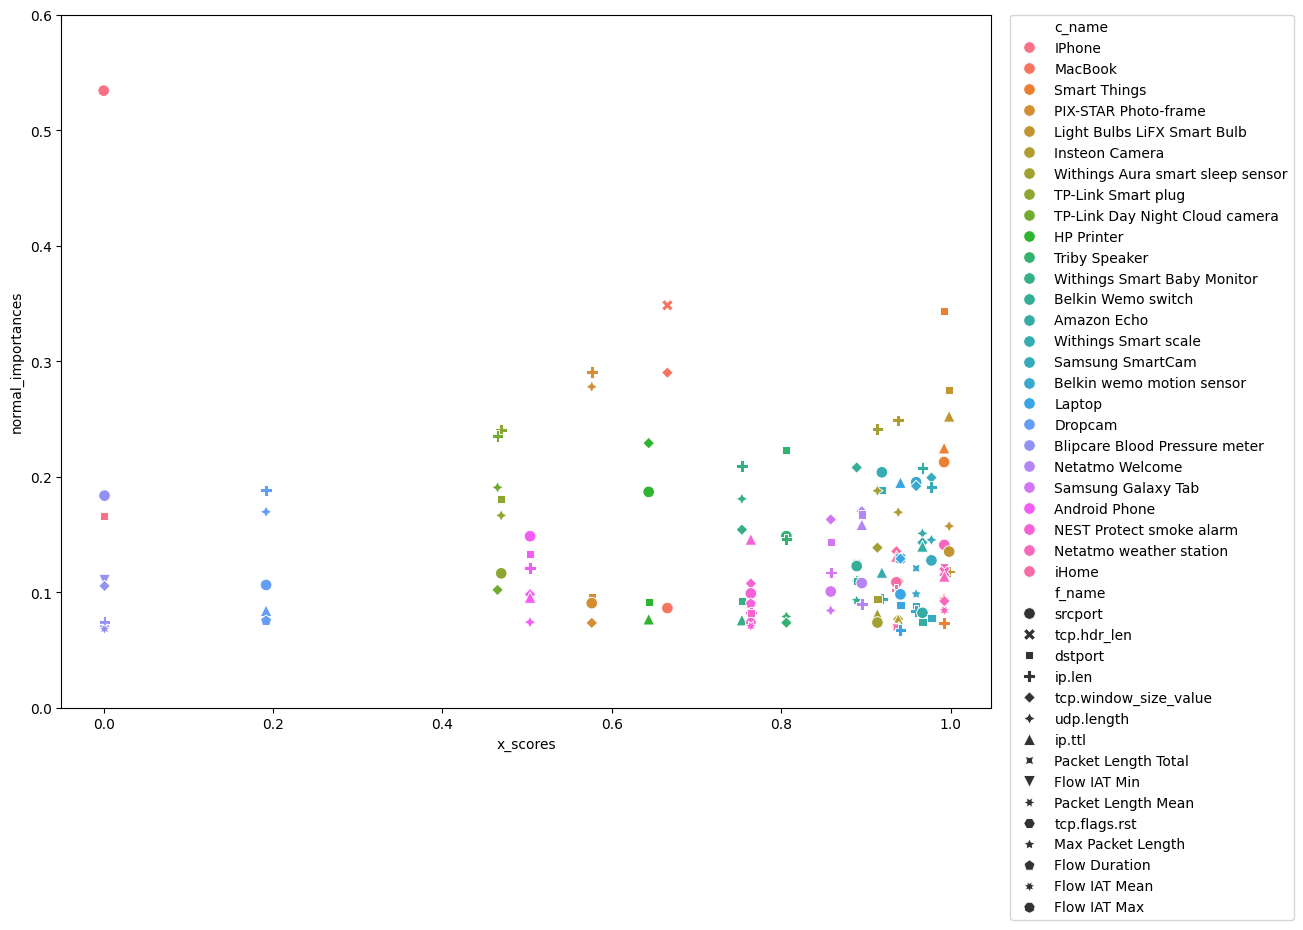

In [176]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=density_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='c_name', style="f_name", s=70)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(0, 0.6)
plt.show()

### Running Hamming Distance on the data obtained after Outlier Detection

In [26]:
## Generate Binary Array per class for inlier features
def generate_binary_arrays(df, binary_array_dict):
    binary_array = [0]*len(feats_all)
    
    for i in range(0, len(df['outlier'].to_list())):
        if df['outlier'].to_list()[i] == False:
            binary_array[df['f_name_ord'].to_list()[i]] = 1
    
    # binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['BinaryArray'] = [binary_array]*len(df['outlier'])
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df

def generate_feature_importance_arrays(df, binary_array_dict):
    binary_array = [0]*len(feats_all)
    
    for i in range(0, len(df['outlier'].to_list())):
        if df['outlier'].to_list()[i] == False:
            binary_array[df['f_name_ord'].to_list()[i]] = df['normal_importances'].to_list()[i]
    
    # binary_array = [int(i == False) for i in df['outlier'].to_list()]
    df['ImportanceArray'] = [binary_array]*len(df['outlier'])
    binary_array_dict[df['c_name'].to_list()[0]] = binary_array
    return df
    
def assign_clusters(df, clustering_result, classes, clustering_method):
    df[clustering_method] = clustering_result[classes.index(df['c_name'].to_list()[0])]
    return df

def weighted_hamming_dist_by_importance_snd(BinaryArray_dict, ImportanceArray_dict, feats):  
    h_distance = []
    classes_for_distance = BinaryArray_dict.keys()
    for c1 in classes_for_distance:
        distance_c1 = []
        for c2 in classes_for_distance:
            distance = 0
            for feat_ind in range(0, len(feats)):
                ### If both classes use or not use the related feature
                if BinaryArray_dict[c1][feat_ind] == BinaryArray_dict[c2][feat_ind]:
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + abs(ImportanceArray_dict[c1][feat_ind] -  ImportanceArray_dict[c2][feat_ind])
                else:
                    # distance = distance + 1
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + ImportanceArray_dict[c1][feat_ind]
                    else:
                        distance = distance + ImportanceArray_dict[c2][feat_ind]        
            distance_c1.append(distance)
        h_distance.append(distance_c1)
    return h_distance

def weighted_hamming_dist_by_importance(BinaryArray_dict, ImportanceArray_dict, feats):  
    h_distance = []
    classes_for_distance = BinaryArray_dict.keys()
    for c1 in classes_for_distance:
        distance_c1 = []
        for c2 in classes_for_distance:
            distance = 0
            for feat_ind in range(0, len(feats)):
                ### If both classes use or not use the related feature
                if BinaryArray_dict[c1][feat_ind] == BinaryArray_dict[c2][feat_ind]:
                    if BinaryArray_dict[c1][feat_ind] == 1:
                        distance = distance + abs(ImportanceArray_dict[c1][feat_ind] -  ImportanceArray_dict[c2][feat_ind])
                else:
                    distance = distance + 1
            distance_c1.append(distance)
        h_distance.append(distance_c1)
    return h_distance

def weighted_hamming_dist_by_score(distance_matrix, classes_ordered, df):
    weighted_distance_matrix = distance_matrix.copy()
    ## get the classes in order
    classes_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['c_name'].to_list()
    scores_ordered = df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)['x_scores'].to_list()
    
    for i in range(0, len(weighted_distance_matrix)):
        for j in range(0, len(weighted_distance_matrix)):
            first_c_name = classes_ordered[i]
            second_c_name = classes_ordered[j]
            score_difference = abs(scores_ordered[i] - scores_ordered[j]) 
            # print(first_c_name, second_c_name, score_difference, weighted_distance_matrix[i][j])
            weighted_distance_matrix[i][j] = score_difference*weighted_distance_matrix[i][j]
            # print(weighted_distance_matrix[i][j])
    
    return weighted_distance_matrix

def generate_data_to_cluster(classes_to_cluster, classes_ordered):
    classes_ordered_temp = []
    for i in classes_ordered:
        if i in classes_to_cluster:
            classes_ordered_temp.append(i)
    
    data_to_cluster = density_df[density_df['c_name'].isin(classes_to_cluster)]
    data_to_cluster_inliers_df = density_inliers_df[density_inliers_df['c_name'].isin(classes_to_cluster)]
    
    data_to_cluster = data_to_cluster[data_to_cluster['x_scores'] > 0.1]
    data_to_cluster_inliers_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['x_scores'] > 0.1]
    
    return classes_ordered_temp, data_to_cluster, data_to_cluster_inliers_df

def get_statistics_of_clustering(classes_to_cluster, score_per_class_df, clustering_result):
    ### To get statistics ###
    classes = classes_to_cluster
    score_per_class_df = score_per_class_df[score_per_class_df['class'].isin(classes_to_cluster)]
    all_classes_in_cluster_order = []
    score_per_class_df['Cluster_F1_Score'] = -1 
    score_per_class_df['Cluster'] = list(clustering_result) + [-1]*(len(classes)- len(clustering_result))
    #
    x = score_per_class_df.groupby(by='Cluster')['class'].apply(list).to_dict()
    ## Get the classes in the order of clusters
    for cl in x.values():
        all_classes_in_cluster_order.extend(cl)
    ##
    cluster_info = pd.DataFrame()
    cluster_info['Cluster'] = x.keys()
    cluster_info['Class List'] = x.values()
    cluster_info['Feature List'] = [-1]*len(cluster_info)
    cluster_info['Depth'] =  -1 
    cluster_info['Tree'] =  -1 
    cluster_info['Feats'] =  -1 
    #
    pd.set_option('max_colwidth', None)
    return cluster_info

#### If you want to run clustering algorithm for specific number of clusters:

In [27]:
classes_analy = []
classes_analy_df = pd.DataFrame(classes_analy,  columns=['class'])

In [28]:
classes_ordered, data_to_cluster, data_to_cluster_inliers_df = generate_data_to_cluster(classes_analy, classes_ordered_main_model)

#### Otherwise:

In [29]:
classes_ordered, data_to_cluster, data_to_cluster_inliers_df = generate_data_to_cluster(classes, classes_ordered_main_model)

#### ---

In [30]:
#### CALL generate_binary_arrays to GENERATE BINARY ARRAY STRINGS to check if the feature is inlier or outlier
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feats_all, range(len(feats_all)))
#
BinaryArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster['f_name_ord'] = data_to_cluster['f_name'].replace(feats_all, range(len(feats_all)))
#
# Generate Binary Array
ord_param = 'f_name_ord'
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_binary_arrays, binary_array_dict=BinaryArray_dict)
# 
## Generate Feature Importance Array
ImportanceArray_dict = dict.fromkeys(data_to_cluster.sort_values(by='x_scores', ascending=False)['c_name'], None)
data_to_cluster = data_to_cluster.sort_values(by=ord_param,ascending=True).groupby('c_name', group_keys=False).apply(generate_feature_importance_arrays, binary_array_dict=ImportanceArray_dict)

In [31]:
#### Calculate Hamming Distance weighted with feature importance differences
weighted_hamming_distance = weighted_hamming_dist_by_importance(BinaryArray_dict, ImportanceArray_dict, feats_all)
#### Weighted Hamming Distance multiplied by F1 Score difference
weighted_hamming_distance = weighted_hamming_dist_by_score(weighted_hamming_distance, classes_ordered, data_to_cluster_inliers_df)

In [32]:
weighted_hamming_distance_df = pd.DataFrame(weighted_hamming_distance, columns=classes_ordered[:24])
weighted_hamming_distance_df['Label'] = classes_ordered[:24]

In [35]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=8, linkage='complete', affinity='precomputed')
#
clusters_average = model_average.fit_predict(weighted_hamming_distance)
#
# toy_data_df['AGGLOMERATIVE'] = clusters_average
weighted_hamming_distance_df['Cluster'] = clusters_average
clusters_average

array([3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 6, 6, 5, 5, 2, 2, 0, 0, 0,
       0, 7])

2
Silhouette score: 0.66
3
Silhouette score: 0.66
4
Silhouette score: 0.70
5
Silhouette score: 0.54
6
Silhouette score: 0.60
7
Silhouette score: 0.50
8
Silhouette score: 0.58
9
Silhouette score: 0.56
10
Silhouette score: 0.58
11
Silhouette score: 0.63
12
Silhouette score: 0.67
13
Silhouette score: 0.68
14
Silhouette score: 0.67
15
Silhouette score: 0.67
16
Silhouette score: 0.66
17
Silhouette score: 0.60
18
Silhouette score: 0.64
19
Silhouette score: 0.50


Text(0, 0.5, 'Silhouette score')

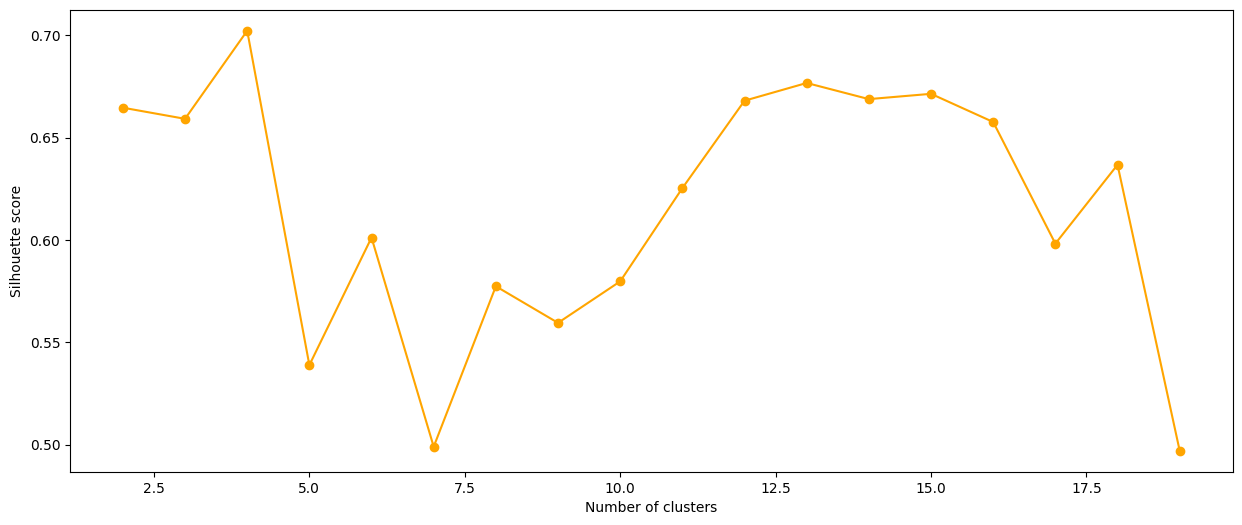

In [36]:
import numpy as np

def silhouette_score(dist_matrix, distance_matrix_df, clustering_results, n_of_classes, n_of_clusters):
    """
    Compute the silhouette score for the clustering.
    
    Parameters:
    - dist_matrix: 2D numpy array, the precomputed distance matrix
    - labels: 1D numpy array, the cluster labels for each point
    
    Returns:
    - score: float, the silhouette score
    """
    silhouette_scores = {}
    silhouette_scores_total = 0
    count_i = 0
    for i in range(n_of_classes):
        c_name = classes_ordered[i]
        cluster = clustering_results[i]
        # print(c_name, cluster)
        cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
        if len(cluster_points)==1:
            # print('continue')
            continue
        else:
            count_i = count_i + 1
        # print(cluster_points)
        # print([distance_matrix_df[distance_matrix_df['Label'] == c_name]])
        # print([distance_matrix_df[distance_matrix_df['Label'] == c_name][j].to_list()[0] for j in cluster_points])
        # a_i = np.mean([distance_matrix_df[distance_matrix_df['Label'] == c_name][j].to_list()[0] for j in cluster_points])
        a_i = np.sum([distance_matrix_df[distance_matrix_df['Label'] == c_name][j].to_list()[0] for j in cluster_points])/(len(cluster_points) - 1)
        # print(a_i)

        # a_i = np.mean(dist_matrix[i, same_cluster]) if np.sum(same_cluster) > 1 else 0

        b_i = np.inf
        for label in range(0, n_of_clusters):
            if label != cluster:
                other_cluster = label
                other_cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == other_cluster]['Label'].to_list()
                b_i = min(b_i, np.mean([distance_matrix_df[distance_matrix_df['Label'] == c_name][j].to_list()[0] for j in other_cluster_points]))
        # print(b_i)
        # if c_name == 'Dropcam':
        #     print(a_i, b_i, (b_i - a_i) / max(a_i, b_i))
        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
        silhouette_scores_total = silhouette_scores_total + silhouette_scores[i]
    # print(np.sum(silhouette_scores.values()))
    # print(silhouette_scores)
    # print(count_i)
    return silhouette_scores_total/count_i

all_scores = []
n_of_clusters = list(range(2, 20)) #------Number of Clusters in the data
for n_clusters in range(2,20):
    # Initialize the Agglomerative clustering model
    model_average = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete', affinity='precomputed')
    #
    clusters_average = model_average.fit_predict(weighted_hamming_distance)
    weighted_hamming_distance_df['Cluster'] = clusters_average
    # print(len(clusters_average))
    score = silhouette_score(np.array(weighted_hamming_distance), weighted_hamming_distance_df, clusters_average, 24, n_clusters)
    # print(f"Cluster labels: {clusters_average}")
    print(n_clusters)
    print(f"Silhouette score: {score:.2f}")
    all_scores.append(score)
    
plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, all_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")


2 0.6645821687238548 0.16458216872385478
3 0.6591426457348185 0.3258093124014852
4 0.6729244619766871 0.4229244619766871
5 0.5163897661597243 0.3163897661597243
6 0.576081059910431 0.4094143932437644
7 0.4781770862476337 0.33531994339049087
8 0.5532859130464169 0.42828591304641694
9 0.5361553334125007 0.42504422230138955
10 0.5555831196654996 0.4555831196654996
11 0.5992342972330001 0.5083252063239092
12 0.5844937704887879 0.5011604371554546
13 0.5638824135241944 0.4869593366011175
14 0.5015787289851387 0.43015015755656727
15 0.4475698750944275 0.3809032084277609
16 0.3835947865208247 0.3210947865208247
17 0.3240108505988066 0.26518732118704186
18 0.2918155943710569 0.23626003881550137
19 0.2070875543950675 0.1544559754476991
[0.16458216872385478, 0.3258093124014852, 0.4229244619766871, 0.3163897661597243, 0.4094143932437644, 0.33531994339049087, 0.42828591304641694, 0.42504422230138955, 0.4555831196654996, 0.5083252063239092, 0.5011604371554546, 0.4869593366011175, 0.43015015755656727

Text(0, 0.5, 'Silhouette score')

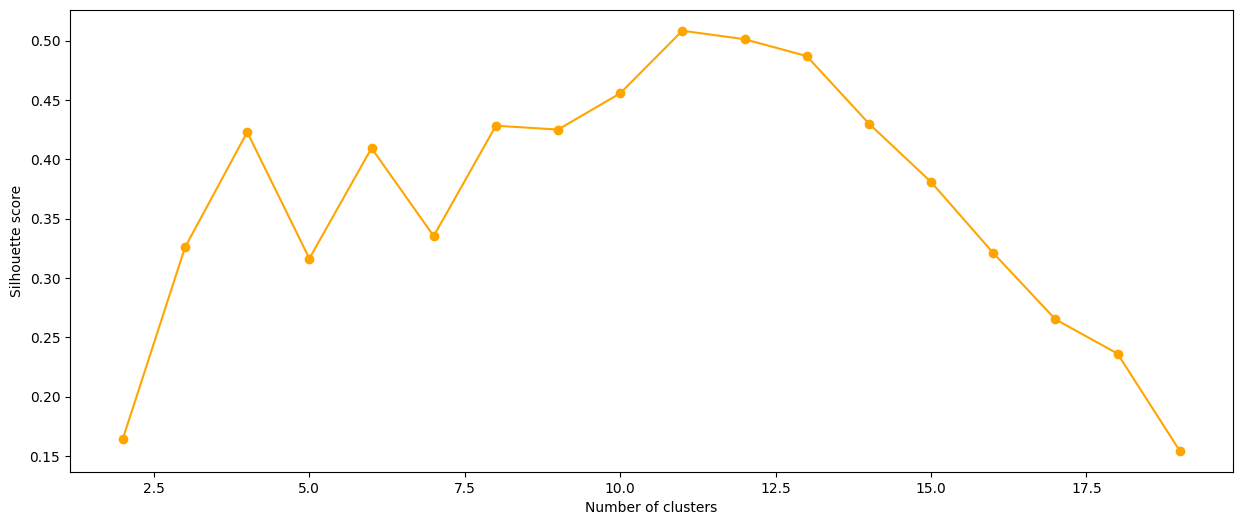

In [37]:
##### Silhouette score #####
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

def calculate_silhoutte_score(data, n_of_cluster):
    
    model_average = AgglomerativeClustering(n_clusters=n_of_cluster, linkage='complete', affinity='precomputed')
    clustering_results = model_average.fit_predict(data)
    silhouette_score_val = silhouette_score(data, clustering_results, metric='precomputed')
    return silhouette_score_val

n_of_clusters = list(range(2, 20)) #------Number of Clusters in the data
avg_scores = []
for n_of_cluster in n_of_clusters: 
    score = calculate_silhoutte_score(weighted_hamming_distance, n_of_cluster)
    # modified_score_penalty = score - ((len(weighted_hamming_distance)/n_of_cluster)/10)
    modified_score_penalty = score - (1/n_of_cluster)
    print(n_of_cluster, score, modified_score_penalty)
    avg_scores.append(modified_score_penalty)
print(avg_scores) 
plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

[-0.12708449794281185, 0.03414264573481851, 0.047924461976687094, 0.058056432826391, 0.1177477265770977, 0.019843752914300405, 0.21995257971308363, 0.20282200007916734, 0.30558311966549956, 0.4325676305663335, 0.4178271038221213, 0.43888241352419444, 0.37657872898513867, 0.3225698750944275, 0.2585947865208247, 0.19901085059880658, 0.16681559437105692, 0.12375422106173418]


Text(0, 0.5, 'Silhouette score')

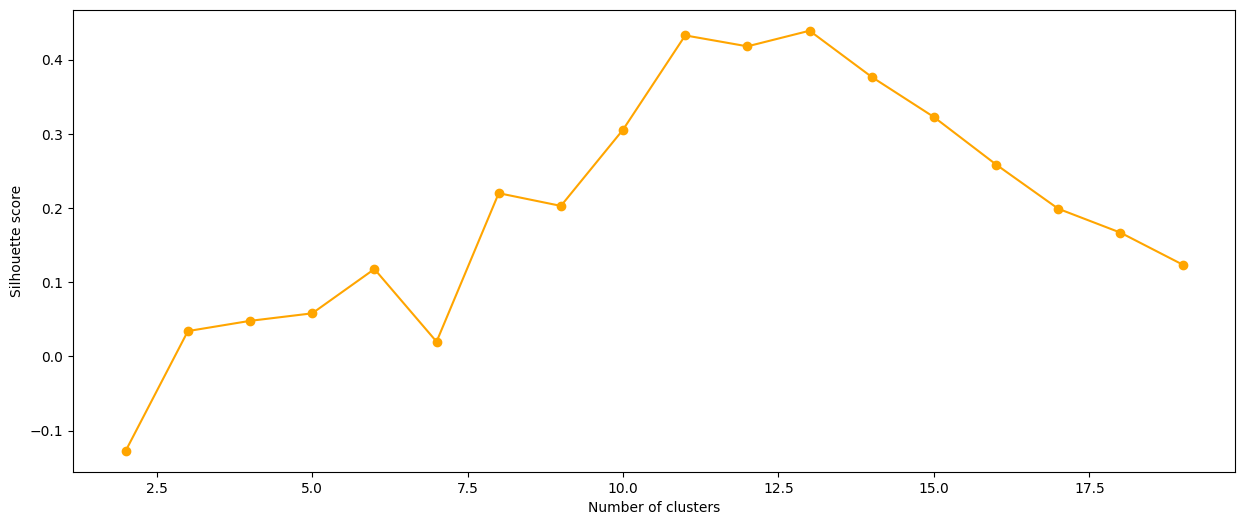

In [89]:
##### Silhouette score #####
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

def calculate_silhoutte_score(data, n_of_cluster):
    
    model_average = AgglomerativeClustering(n_clusters=n_of_cluster, linkage='complete', affinity='precomputed')
    clustering_results = model_average.fit_predict(data)
    silhouette_score_val = silhouette_score(data, clustering_results, metric='precomputed')
    return silhouette_score_val, clustering_results

n_of_clusters = list(range(2, 20)) #------Number of Clusters in the data
avg_scores = []
for n_of_cluster in n_of_clusters: 
    score, clustering_results = calculate_silhoutte_score(weighted_hamming_distance, n_of_cluster)
    # modified_score_penalty = score - ((len(weighted_hamming_distance)/n_of_cluster)/10)
    count_n_of_cluster = [0 for i in range(0, n_of_cluster)]
    for c_result in clustering_results:
        count_n_of_cluster[c_result] = count_n_of_cluster[c_result] + 1
    max_class_in_cluster = max(count_n_of_cluster)   
    # modified_score_penalty = score - (1/n_of_cluster)
    modified_score_penalty = score - (max_class_in_cluster/len(weighted_hamming_distance))
    # print(n_of_cluster, score, modified_score_penalty)
    avg_scores.append(modified_score_penalty)
print(avg_scores) 
plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")

In [90]:
# ##### Davies-Bouldin Index with Medoid #####
# def calculate_medoid(distance_matrix_df, cluster):
    
#     temp_df = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]
#     labels = temp_df['Label'].to_list()
#     temp_df = temp_df[labels]
#     temp_df['Total'] = temp_df.sum(axis=1)

#     total_distance = temp_df['Total'].to_list()
#     min_distance = min(total_distance)
#     min_distance_ind = total_distance.index(min_distance)
#     return classes_ordered.index(labels[min_distance_ind])

# def calculate_within_cluster_scatter(distance_matrix_df, cluster_points, medoid):
#     distance_matrix_temp = distance_matrix_df[distance_matrix_df['Label'] == medoid]
#     return distance_matrix_temp[cluster_points].mean(axis=1).to_list()[0]

# def calculate_between_cluster_distance(distance_matrix_df, medoid1, medoid2):
#     return distance_matrix_df[distance_matrix_df['Label'] == medoid1][medoid2].to_list()[0]

# # Function to calculate Davies-Bouldin Index
# from sklearn.metrics import pairwise_distances
# def calculate_davies_bouldin_index_manual(distance_matrix, n_of_clusters):
    
#     ## Calculate medoid 
#     medoid_indices = np.array([calculate_medoid(distance_matrix, cluster_no) for cluster_no in range(0, n_of_clusters)])
#     # print(medoid_indices)
#     ## Calculate S

#     S = np.array([calculate_within_cluster_scatter(distance_matrix, distance_matrix[distance_matrix['Cluster'] == cluster_no]['Label'].to_list(), classes_ordered[medoid_indices[cluster_no]]) for cluster_no in range(0, n_of_clusters) ])
#     # print(S)
#     ## Calculate R
#     R = np.zeros((n_of_clusters, n_of_clusters))
#     for i in range(n_of_clusters):
#         for j in range(i + 1, n_of_clusters):
#             M = calculate_between_cluster_distance(distance_matrix, classes_ordered[medoid_indices[i]], classes_ordered[medoid_indices[j]])
#             # print(medoid_indices[i],medoid_indices[j],M)
#             R[i, j] = (S[i] + S[j]) / M
#             R[j, i] = R[i, j]
    
#     D = np.max(R, axis=1)
    
#     # # Compute the Davies-Bouldin Index
#     # db_index = np.mean([max([(S[i] + S[j]) / M[i][j] for j in range(n_clusters) if j != i]) for i in range(n_clusters)])
#     # print(db_index)
#     return np.mean(D)
    
# avg_scores = []
# for n_cluster in range(2, 15):
#     # Initialize the Agglomerative clustering model
#     model_average = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete', affinity='precomputed')
#     #
#     clusters_average = model_average.fit_predict(weighted_hamming_distance)
#     #
#     # toy_data_df['AGGLOMERATIVE'] = clusters_average
#     weighted_hamming_distance_df['Cluster'] = clusters_average
    
#     davies_bouldin_score = calculate_davies_bouldin_index_manual(weighted_hamming_distance_df, n_cluster)
#     count_n_of_cluster = [0 for i in range(0, n_of_cluster)]
#     for c_result in clusters_average:
#         count_n_of_cluster[c_result] = count_n_of_cluster[c_result] + 1
#     max_class_in_cluster = max(count_n_of_cluster)  
#     # modified_davies_bouldin_score = davies_bouldin_score + (1/n_cluster)
#     # modified_davies_bouldin_score = davies_bouldin_score + ((len(weighted_hamming_distance)/n_cluster)/10)
#     modified_davies_bouldin_score = davies_bouldin_score + (max_class_in_cluster/len(weighted_hamming_distance))
#     avg_scores.append(modified_davies_bouldin_score)
#     print(n_cluster, davies_bouldin_score, modified_davies_bouldin_score)
    
# # calculate_davies_bouldin_index_manual_Centroid(ImportanceArray_dict, BinaryArray_dict, weighted_hamming_distance_df, 8, 31)
# n_of_clusters = list(range(2, 15)) #------Number of Clusters in the data
# plt.figure(figsize=(15,6))
 
# plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
# plt.xlabel("Number of clusters")
# plt.ylabel("Davies-Bouldin Index")


                               c_name  x_scores
3         Light Bulbs LiFX Smart Bulb  0.998366
21            Netatmo weather station  0.992718
33                       Smart Things  0.992392
45                   Samsung SmartCam  0.977446
61                        Amazon Echo  0.966843
81          Belkin wemo motion sensor  0.959426
94                             Laptop  0.940845
106                    Insteon Camera  0.938228
120                             iHome  0.936027
141              Withings Smart scale  0.918919
151  Withings Aura smart sleep sensor  0.913661
165                   Netatmo Welcome  0.895281
180                Belkin Wemo switch  0.889191
195                Samsung Galaxy Tab  0.858565
213                     Triby Speaker  0.806126
229          NEST Protect smoke alarm  0.764210
241       Withings Smart Baby Monitor  0.753645
260                           MacBook  0.665657
270                        HP Printer  0.643552
286              PIX-STAR Photo-frame  0

Text(0, 0.5, 'Davies-Bouldin Index')

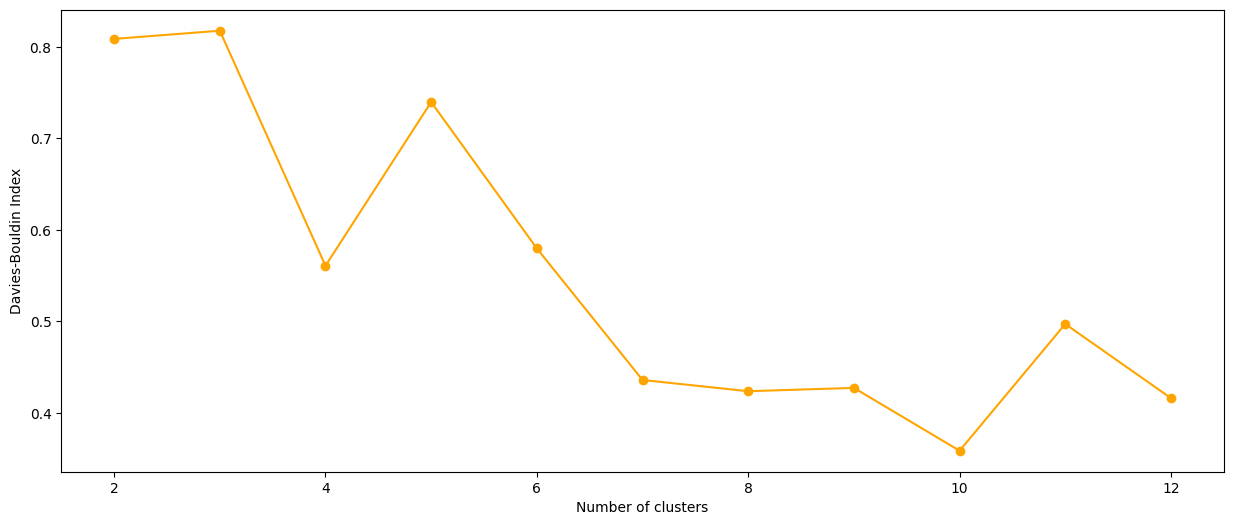

In [143]:
##### Davies-Bouldin Index with Centroids #####
def calculate_centroid(X, distance_matrix_df, cluster, number_of_feats):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    centroid = []
    for i in range(0, number_of_feats):
        total_axis = 0
        count_zero = 0
        count_non_zero = 0
        for cl in cluster_points:
            if X[cl][i] == 0:
                count_zero = count_zero + 1
            else:
                count_non_zero = count_non_zero + 1
            total_axis = total_axis + X[cl][i]
        # centroid_axis = 0
        # if count_non_zero!=0:
        #     centroid_axis = total_axis/count_non_zero
        centroid_axis = total_axis/(count_non_zero+count_zero)
            # print('count_non_zero: ', count_non_zero, centroid_axis)
        centroid.append(centroid_axis)
        # centroid.append(total_axis/len(cluster_points))
    return centroid

def calculate_centroid_score(X, distance_matrix_df, cluster, score_per_class_df):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    scores_ordered = score_per_class_df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)[['c_name', 'x_scores']]
    print(scores_ordered)
    total_score = 0
    for cl in cluster_points:
        total_score = total_score + scores_ordered[scores_ordered['c_name'] == cl]['x_scores'].to_list()[0]
    return total_score/len(cluster_points)

def calculate_within_cluster_distance(X, BinaryArray_dict, distance_matrix_df, score_per_class_df, cluster, centroid, centroid_score, number_of_feats):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    scores_ordered = score_per_class_df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)[['c_name', 'x_scores']]
    # print(scores_ordered)
    total_distance = 0
    distances = []
    # print(cluster_points)
    for cl in cluster_points:
        distance = 0
        score_diff = abs(centroid_score - scores_ordered[scores_ordered['c_name'] == cl]['x_scores'].to_list()[0])
        # print(cl, X[cl])
        # print(BinaryArray_dict[cl])
        for feat_ind in range(0, number_of_feats):
            ### If both classes use or not use the related feature
            if BinaryArray_dict[cl][feat_ind] == 1:
                if centroid[feat_ind] != 0:
                    distance = distance + abs(X[cl][feat_ind] -  centroid[feat_ind])
                else:
                    distance = distance + 1
            elif BinaryArray_dict[cl][feat_ind] == 0:
                if centroid[feat_ind] == 0:
                    distance = distance
                else:
                    distance = distance + 1         
        distances.append(distance*score_diff)
        total_distance = total_distance + distance*score_diff
    # print(distances)
    return total_distance/len(cluster_points)

def calculate_distance_between_clusters(centroid1_loc, centroid2_loc, centroid1_score, centroid2_score, number_of_feats):
    distance = 0
    for feat_ind in range(0, number_of_feats):
        ### If both classes use or not use the related feature
        if (centroid1_loc[feat_ind] != 0) and (centroid2_loc[feat_ind] != 0):
                distance = distance + abs(centroid1_loc[feat_ind] -  centroid2_loc[feat_ind])

        elif (centroid1_loc[feat_ind] == 0) and (centroid2_loc[feat_ind] != 0):
            distance = distance + 1  
            
        elif (centroid2_loc[feat_ind] == 0) and (centroid1_loc[feat_ind] != 0):
            distance = distance + 1  
            
    return distance*abs(centroid1_score - centroid2_score) 
    
    
# Function to calculate Davies-Bouldin Index
from sklearn.metrics import pairwise_distances
def calculate_davies_bouldin_index_manual_Centroid(X, BinaryArray_dict, distance_matrix_df, data_to_cluster_inliers_df, n_of_clusters, n_of_features):
    
    ## Calculate centroids 
    centroids = np.array([calculate_centroid(X, distance_matrix_df, cluster_no, 31) for cluster_no in range(0, n_of_clusters)])
    centroid_scores = np.array([calculate_centroid_score(X, distance_matrix_df, cluster_no, data_to_cluster_inliers_df) for cluster_no in range(0, n_of_clusters)])
    # print(centroids)
    # print(medoid_indices)
    ## Calculate S
    S = np.array([calculate_within_cluster_distance(X, BinaryArray_dict, weighted_hamming_distance_df, data_to_cluster_inliers_df, cluster_no, centroids[cluster_no], centroid_scores[cluster_no], n_of_features) for cluster_no in range(0, n_of_clusters) ])
    # # print(S)
    ## Calculate R
    list_temp = []
    R = np.zeros((n_of_clusters, n_of_clusters))
    count_non_zero = 0
    for i in range(n_of_clusters):
        # max_ratio = -np.inf
        # print('i: ', i)
        for j in range(i + 1, n_of_clusters):
            M = calculate_distance_between_clusters(centroids[i], centroids[j], centroid_scores[i], centroid_scores[j], n_of_features)
            R[i, j] = (S[i] + S[j]) / M
            R[j, i] = R[i, j]

    D = np.max(R, axis=1)
    # print(n_of_clusters, D)
    # print('MEAN: ', n_of_clusters, np.mean(list_temp))
    # # # Compute the Davies-Bouldin Index
    # # db_index = np.mean([max([(S[i] + S[j]) / M[i][j] for j in range(n_clusters) if j != i]) for i in range(n_clusters)])
    # # print(db_index)
    # print(D)
    # return sum(list_temp)/count_non_zero
    return np.mean(D)

avg_scores = []
for n_cluster in range(2, 13):
    # Initialize the Agglomerative clustering model
    model_average = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete', affinity='precomputed')
    #
    clusters_average = model_average.fit_predict(weighted_hamming_distance)
    #
    # toy_data_df['AGGLOMERATIVE'] = clusters_average
    weighted_hamming_distance_df['Cluster'] = clusters_average
    
    davies_bouldin_score = calculate_davies_bouldin_index_manual_Centroid(ImportanceArray_dict, BinaryArray_dict, weighted_hamming_distance_df, data_to_cluster_inliers_df, n_cluster, 31)
    
    # count_n_of_cluster = [0 for i in range(0, n_cluster)]
    # for c_result in clusters_average:
    #     count_n_of_cluster[c_result] = count_n_of_cluster[c_result] + 1
    # max_class_in_cluster = max(count_n_of_cluster)  
    modified_davies_bouldin_score = davies_bouldin_score + (1/n_cluster)
    # modified_davies_bouldin_score = davies_bouldin_score + ((len(weighted_hamming_distance)/n_cluster)/10)
    # modified_davies_bouldin_score = davies_bouldin_score + (max_class_in_cluster/len(weighted_hamming_distance))
    
    avg_scores.append(modified_davies_bouldin_score)
    # print(n_cluster, davies_bouldin_score, modified_davies_bouldin_score)
    
# calculate_davies_bouldin_index_manual_Centroid(ImportanceArray_dict, BinaryArray_dict, weighted_hamming_distance_df, 8, 31)
n_of_clusters = list(range(2, 13)) #------Number of Clusters in the data
plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Bouldin Index")
    

Text(0, 0.5, 'Dunn Index')

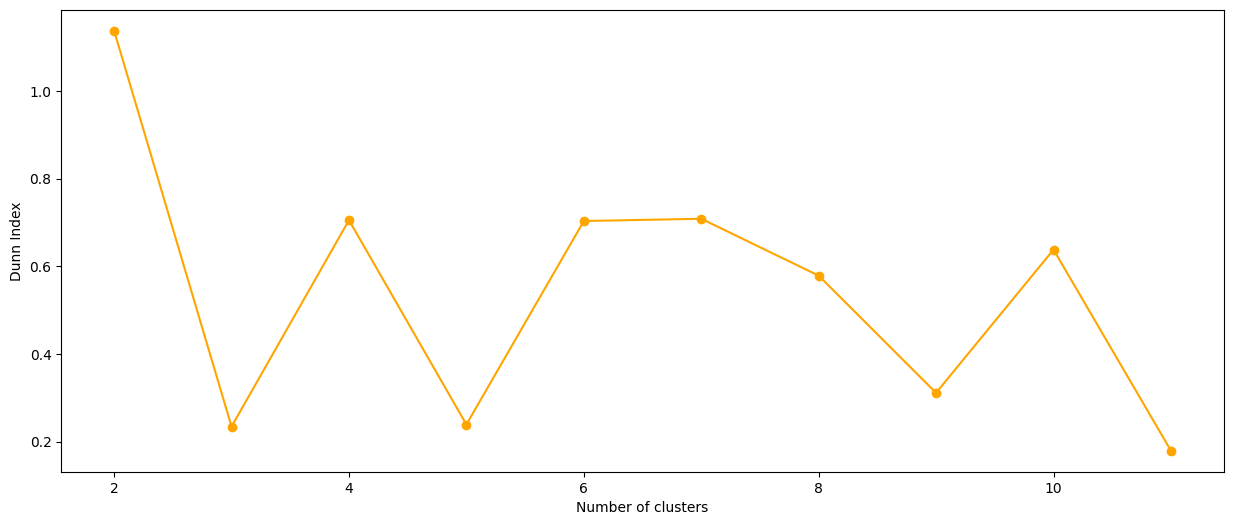

In [138]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist

##### Dunn Index with Centroids #####
def calculate_centroid(X, distance_matrix_df, cluster, number_of_feats):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    centroid = []
    for i in range(0, number_of_feats):
        total_axis = 0
        count_zero = 0
        count_non_zero = 0
        for cl in cluster_points:
            if X[cl][i] == 0:
                count_zero = count_zero + 1
            else:
                count_non_zero = count_non_zero + 1
            total_axis = total_axis + X[cl][i]
        # centroid_axis = 0
        # if count_non_zero!=0:
        #     centroid_axis = total_axis/count_non_zero
        centroid_axis = total_axis/(count_non_zero+count_zero)
            # print('count_non_zero: ', count_non_zero, centroid_axis)
        centroid.append(centroid_axis)
        # centroid.append(total_axis/len(cluster_points))
    return centroid

def calculate_centroid_score(X, distance_matrix_df, cluster, score_per_class_df):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    scores_ordered = score_per_class_df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)[['c_name', 'x_scores']]
    total_score = 0
    for cl in cluster_points:
        total_score = total_score + scores_ordered[scores_ordered['c_name'] == cl]['x_scores'].to_list()[0]
    return total_score/len(cluster_points)

def calculate_distance_between_clusters(centroid1_loc, centroid2_loc, centroid1_score, centroid2_score, number_of_feats):
    distance = 0
    for feat_ind in range(0, number_of_feats):
        ### If both classes use or not use the related feature
        if (centroid1_loc[feat_ind] != 0) and (centroid2_loc[feat_ind] != 0):
                distance = distance + abs(centroid1_loc[feat_ind] -  centroid2_loc[feat_ind])

        elif (centroid1_loc[feat_ind] == 0) and (centroid2_loc[feat_ind] != 0):
            distance = distance + 1  
            
        elif (centroid2_loc[feat_ind] == 0) and (centroid1_loc[feat_ind] != 0):
            distance = distance + 1  
            
    return distance*abs(centroid1_score - centroid2_score) 

def dunn_index(X, BinaryArray_dict, distance_matrix_df, data_to_cluster_inliers_df, n_of_clusters, n_of_features):
    ## Calculate centroids 
    centroids = np.array([calculate_centroid(X, distance_matrix_df, cluster_no, 31) for cluster_no in range(0, n_of_clusters)])
    centroid_scores = np.array([calculate_centroid_score(X, distance_matrix_df, cluster_no, data_to_cluster_inliers_df) for cluster_no in range(0, n_of_clusters)])
    # print(centroids)
    # print(medoid_indices)
    ## Calculate S
    # S = np.array([calculate_within_cluster_distance(X, BinaryArray_dict, weighted_hamming_distance_df, data_to_cluster_inliers_df, cluster_no, centroids[cluster_no], centroid_scores[cluster_no], n_of_features) for cluster_no in range(0, n_of_clusters) ])

    intra_cluster_distances = []
    inter_cluster_distances = []

    for cluster in range(0, n_of_clusters):
        cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()

        all_distances = []
        for cp_1 in cluster_points:
            for cp_2 in cluster_points:
                all_distances.append(distance_matrix_df[distance_matrix_df['Label'] == cp_1][cp_2].to_list()[0])
        intra_cluster_distances.append(np.max(all_distances))
        
        # print(cluster, intra_cluster_distances)
            

    for i in range(n_of_clusters):
        # max_ratio = -np.inf
        # print('i: ', i)
        for j in range(i + 1, n_of_clusters):
            dist = calculate_distance_between_clusters(centroids[i], centroids[j], centroid_scores[i], centroid_scores[j], n_of_features)
            inter_cluster_distances.append(dist)
    
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)


avg_scores = []
for n_of_cluster in range(2, 12):
    # Initialize the Agglomerative clustering model
    model_average = AgglomerativeClustering(n_clusters=n_of_cluster, linkage='complete', affinity='precomputed')
    #
    clusters_average = model_average.fit_predict(weighted_hamming_distance)
    #
    # toy_data_df['AGGLOMERATIVE'] = clusters_average
    weighted_hamming_distance_df['Cluster'] = clusters_average
    # dunn = dunn_index(X, labels)
    # dunn_indices.append(dunn)
    dunn_score = dunn_index(ImportanceArray_dict, BinaryArray_dict, weighted_hamming_distance_df, data_to_cluster_inliers_df, n_of_cluster, 31)
    
    count_n_of_cluster = [0 for i in range(0, n_of_cluster)]
    for c_result in clusters_average:
        count_n_of_cluster[c_result] = count_n_of_cluster[c_result] + 1
    max_class_in_cluster = max(count_n_of_cluster)  
    modified_dunn_score = dunn_score - (1/n_of_cluster)
    # modified_davies_bouldin_score = davies_bouldin_score + ((len(weighted_hamming_distance)/n_of_cluster)/10)
    # modified_dunn_score = dunn_score - (max_class_in_cluster/len(weighted_hamming_distance))
    # modified_dunn_score = dunn_score - (1/n_of_cluster)
    
    avg_scores.append(modified_dunn_score)
    # print(n_of_cluster, dunn_score, modified_dunn_score)
    
# calculate_davies_bouldin_index_manual_Centroid(ImportanceArray_dict, BinaryArray_dict, weighted_hamming_distance_df, 8, 31)
n_of_clusters = list(range(2, 12)) #------Number of Clusters in the data
plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Dunn Index")

# optimal_clusters = np.argmax(dunn_indices) + 2  # +2 because range starts from 2
# print(f"Optimal number of clusters: {optimal_clusters}")


0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624
0.7923829498103624


Text(0, 0.5, 'Kalinski-Harabasz')

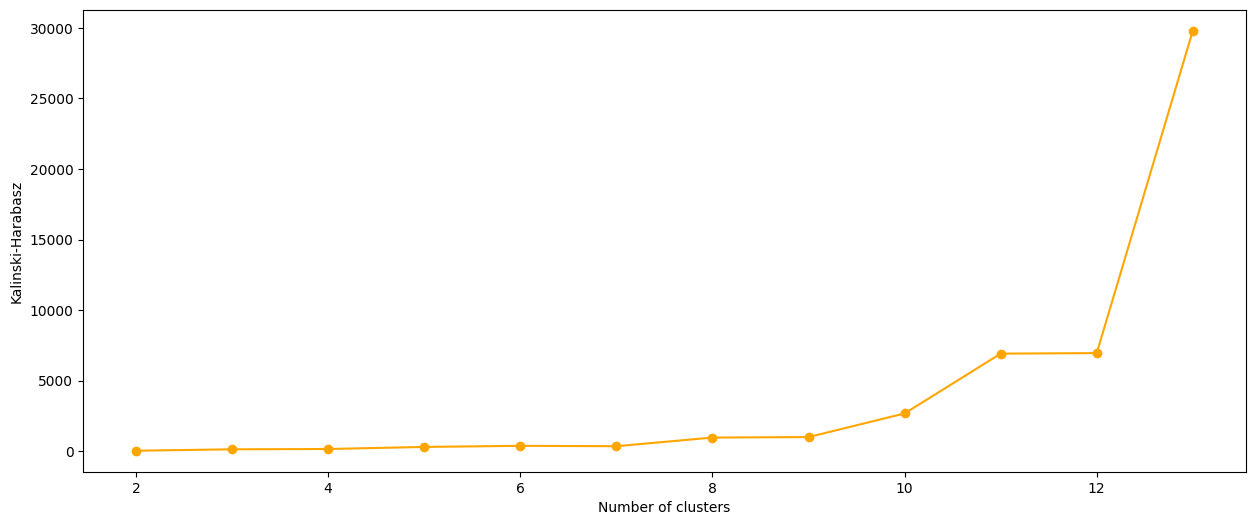

In [210]:
# Perform Agglomerative Clustering using linkage from scipy
def agglomerative_clustering(X, n_of_clusters):
    # Initialize the Agglomerative clustering model
    model_average = AgglomerativeClustering(n_clusters=n_of_clusters, linkage='complete', affinity='precomputed')
    #
    labels = model_average.fit_predict(X)
    return labels

##### Calinski-Harabasz Centroids #####
def calculate_centroid(X, distance_matrix_df, cluster, number_of_feats):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    centroid = []
    for i in range(0, number_of_feats):
        total_axis = 0
        count_zero = 0
        count_non_zero = 0
        for cl in cluster_points:
            if X[cl][i] == 0:
                count_zero = count_zero + 1
            else:
                count_non_zero = count_non_zero + 1
            total_axis = total_axis + X[cl][i]
        # centroid_axis = 0
        # if count_non_zero!=0:
        #     centroid_axis = total_axis/count_non_zero
        centroid_axis = total_axis/(count_non_zero+count_zero)
            # print('count_non_zero: ', count_non_zero, centroid_axis)
        centroid.append(centroid_axis)
        # centroid.append(total_axis/len(cluster_points))
    return centroid

def calculate_centroid_score(X, distance_matrix_df, cluster, score_per_class_df):
    cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
    scores_ordered = score_per_class_df.drop_duplicates(['c_name']).sort_values(by='x_scores', ascending=False)[['c_name', 'x_scores']]
    total_score = 0
    for cl in cluster_points:
        total_score = total_score + scores_ordered[scores_ordered['c_name'] == cl]['x_scores'].to_list()[0]
    return total_score/len(cluster_points)

# Compute the distance between two points
def find_weighted_hamming_distance(loc_1, loc_2, score_1, score_2, number_of_feats):
    # unique_labels = np.unique(labels)
    # W = np.sum([np.sum(cdist(X[labels == label], [centroids[label - 1]], 'euclidean') ** 2) for label in unique_labels])
    
    ### Find the distance between two points
    distance = 0
    for feat_ind in range(0, number_of_feats):
        ### If both classes use or not use the related feature
        if (loc_1[feat_ind] != 0) and (loc_2[feat_ind] != 0):
                distance = distance + abs(loc_1[feat_ind] -  loc_2[feat_ind])

        elif (loc_1[feat_ind] == 0) and (loc_2[feat_ind] != 0):
            distance = distance + 1  
            
        elif (loc_2[feat_ind] == 0) and (loc_1[feat_ind] != 0):
            distance = distance + 1  
        
    return distance*abs(score_1 - score_2) 

def within_cluster_dispersion(X, distance_matrix_df, score_per_class, cluster_centroids, controid_scores, number_of_feats):
    class_names = distance_matrix_df['Label'].to_list()
    sum_distance_pow = 0
    for c_name in class_names:
        cluster_of_class = distance_matrix_df[distance_matrix_df['Label']==c_name]['Cluster'].to_list()[0]
        centroid_of_cluster = cluster_centroids[cluster_of_class]
        score_of_cluster = controid_scores[cluster_of_class]
        #
        class_loc = X[c_name]
        class_score = score_per_class[score_per_class['c_name'] == c_name]['x_scores'].to_list()[0]
        
        distance = find_weighted_hamming_distance(class_loc, centroid_of_cluster, class_score, score_of_cluster, number_of_feats)
        distance_pow = distance*distance
        sum_distance_pow = sum_distance_pow + distance_pow
        
        
        # np.sum([np.sum(cdist(X[labels == label], [centroids[label - 1]], 'euclidean') ** 2) for label in unique_labels])
        # [np.sum(cdist(X[labels == label], [centroids[label - 1]], 'euclidean') ** 2) for label in unique_labels]
        
    return sum_distance_pow

# Compute between-cluster dispersion matrix
def between_cluster_dispersion(X, distance_matrix_df, score_per_class, cluster_centroids, controid_scores, number_of_feats, n_of_clusters):
    overall_mean = []
    for i in range(0, number_of_feats):
        total_axis = 0
        count_zero = 0
        count_non_zero = 0
        for cl in distance_matrix_df['Label'].to_list():
            if X[cl][i] == 0:
                count_zero = count_zero + 1
            else:
                count_non_zero = count_non_zero + 1
            total_axis = total_axis + X[cl][i]
        centroid_axis = total_axis/(count_non_zero+count_zero)
        overall_mean.append(centroid_axis)
        
    overall_mean_score = sum(score_per_class.drop_duplicates(['c_name'])['x_scores'].to_list())/(len(score_per_class.drop_duplicates(['c_name'])['x_scores'].to_list()))
    print(overall_mean_score)

    between_cluster_dispersion_val = 0
    for cluster in range(0, n_of_clusters):
        centroid = cluster_centroids[cluster]
        # print('Cluster:', cluster)
        # print('centroid: ', centroid)
        centroid_score = controid_scores[cluster]
        cluster_points = distance_matrix_df[distance_matrix_df['Cluster'] == cluster]['Label'].to_list()
        dist = find_weighted_hamming_distance(overall_mean, centroid, overall_mean_score, centroid_score, number_of_feats)
        between_cluster_dispersion_val = between_cluster_dispersion_val + len(cluster_points)*(dist*dist)
        
    # B = np.sum([len(X[labels == label]) * np.sum((centroid - overall_mean) ** 2) for label, centroid in enumerate(centroids, 1)])
    return between_cluster_dispersion_val


# Calculate Calinski-Harabasz Index
def calinski_harabasz_index(X, distance_matrix_df, score_per_class, n_of_clusters, n_of_feats, n_of_classes):
    ## Calculate centroids 
    centroids = np.array([calculate_centroid(X, distance_matrix_df, cluster_no, len(feats_all)) for cluster_no in range(0, n_of_clusters)])
    centroid_scores = np.array([calculate_centroid_score(X, distance_matrix_df, cluster_no, score_per_class) for cluster_no in range(0, n_of_clusters)])
    
    W = within_cluster_dispersion(X, distance_matrix_df, score_per_class, centroids, centroid_scores, n_of_feats)
    B = between_cluster_dispersion(X, distance_matrix_df, score_per_class, centroids, centroid_scores, n_of_feats, n_of_clusters)
    
    ch_index = (B / (n_of_clusters - 1)) / (W / (n_of_classes - n_of_clusters))
    return ch_index

avg_scores = []
for n_of_cluster in range(2, 14):
    # The Agglomerative clustering
    clusters_average = agglomerative_clustering(weighted_hamming_distance, n_of_cluster)
    weighted_hamming_distance_df['Cluster'] = clusters_average
    # dunn = dunn_index(X, labels)
    # dunn_indices.append(dunn)
    calinski_score = calinski_harabasz_index(ImportanceArray_dict, weighted_hamming_distance_df, data_to_cluster_inliers_df, n_of_cluster, len(feats_all), len(weighted_hamming_distance))
    
    avg_scores.append(calinski_score)
    # print(n_of_cluster, dunn_score, modified_dunn_score)
    
# calculate_davies_bouldin_index_manual_Centroid(ImportanceArray_dict, BinaryArray_dict, weighted_hamming_distance_df, 8, 31)
n_of_clusters = list(range(2, 14)) #------Number of Clusters in the data
plt.figure(figsize=(15,6))
 
plt.plot(n_of_clusters, avg_scores, marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Kalinski-Harabasz")

In [192]:
data_to_cluster_inliers_df

,c_name,f_name,x_scores,normal_importances,y_importances,exp_values,FINAL,normal_importances_100,Feature,outlier,ccum_sum
260,MacBook,tcp.hdr_len,0.665657,0.348343,0.028707,1.029123,2.954339,34.834301,5,False,0.348343
33,Smart Things,dstport,0.992392,0.343712,0.029094,1.029522,2.995307,34.371155,3,False,0.343712
286,PIX-STAR Photo-frame,ip.len,0.576338,0.290704,0.034399,1.034998,3.560320,29.070357,1,False,0.290704
255,MacBook,tcp.window_size_value,0.665657,0.290032,0.034479,1.035080,3.568845,29.003224,0,False,0.638375
287,PIX-STAR Photo-frame,udp.length,0.576338,0.277853,0.035990,1.036646,3.730916,27.785289,2,False,0.568556
...,...,...,...,...,...,...,...,...,...,...,...
31,Smart Things,ip.len,0.992392,0.073387,0.136264,1.145985,15.615658,7.338689,1,False,0.949086
237,NEST Protect smoke alarm,Flow IAT Mean,0.764210,0.070527,0.141790,1.152335,16.338995,7.052667,12,False,0.750660
128,iHome,Packet Length Mean,0.936027,0.070171,0.142509,1.153163,16.433610,7.017103,8,False,0.656378
127,iHome,Packet Length Total,0.936027,0.069746,0.143377,1.154165,16.548076,6.974617,7,False,0.726124


In [188]:
score_per_class_df

,class,f1_score,support
14,Light Bulbs LiFX Smart Bulb,99.836551,1509.0
15,Netatmo weather station,99.271827,248.0
19,Smart Things,99.239209,592.0
2,Samsung SmartCam,97.744553,13334.0
3,Amazon Echo,96.684257,4649.0
5,Belkin wemo motion sensor,95.942556,3282.0
0,Laptop,94.084491,11484.0
1,Insteon Camera,93.822807,6888.0
20,iHome,93.602732,160.0
22,Withings Smart scale,91.891892,6.0


In [141]:
score_per_class_df

,class,f1_score,support
14,Light Bulbs LiFX Smart Bulb,99.836551,1509.0
15,Netatmo weather station,99.271827,248.0
19,Smart Things,99.239209,592.0
2,Samsung SmartCam,97.744553,13334.0
3,Amazon Echo,96.684257,4649.0
5,Belkin wemo motion sensor,95.942556,3282.0
0,Laptop,94.084491,11484.0
1,Insteon Camera,93.822807,6888.0
20,iHome,93.602732,160.0
22,Withings Smart scale,91.891892,6.0


In [140]:
ImportanceArray_dict

{'Light Bulbs LiFX Smart Bulb': [0.11788856315677726,
  0.2522581219793744,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.1351369273136978,
  0.27534741105204297,
  0,
  0,
  0,
  0.1571486655586132,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'Netatmo weather station': [0,
  0.11367681717881835,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.14090502138552366,
  0.12200406956012172,
  0,
  0.09228207235420256,
  0.11755735232515259,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.08418846776831083,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'Smart Things': [0.07338688908343335,
  0.22470920316030712,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.21261821873899348,
  0.3437115547328244,
  0,
  0,
  0,
  0.09466051313296522,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'Samsung SmartCam': [0.19117237992079003,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.12749223094337822,
  0.0774148653502353,
  0,
  0.19915437637985747,
  0,
  0.145287675

In [137]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import linkage, fcluster

# Example data
X = np.random.rand(100, 2)

# Perform Agglomerative Clustering using linkage from scipy
def agglomerative_clustering(X, n_clusters):
    Z = linkage(X, 'ward')
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    return labels

# Compute centroids of clusters
def compute_centroids(X, labels):
    unique_labels = np.unique(labels)
    centroids = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    return centroids

# Compute within-cluster dispersion matrix
def within_cluster_dispersion(X, labels, centroids):
    unique_labels = np.unique(labels)
    W = np.sum([np.sum(cdist(X[labels == label], [centroids[label - 1]], 'euclidean') ** 2) for label in unique_labels])
    return W

# Compute between-cluster dispersion matrix
def between_cluster_dispersion(X, labels, centroids):
    overall_mean = X.mean(axis=0)
    unique_labels = np.unique(labels)
    B = np.sum([len(X[labels == label]) * np.sum((centroid - overall_mean) ** 2) for label, centroid in enumerate(centroids, 1)])
    return B

# Calculate Calinski-Harabasz Index
def calinski_harabasz_index(X, labels):
    n_samples = X.shape[0]
    n_clusters = len(np.unique(labels))
    
    centroids = compute_centroids(X, labels)
    W = within_cluster_dispersion(X, labels, centroids)
    B = between_cluster_dispersion(X, labels, centroids)
    
    ch_index = (B / (n_clusters - 1)) / (W / (n_samples - n_clusters))
    return ch_index

# Perform clustering and calculate CH Index
n_clusters = 3  # Example number of clusters
labels = agglomerative_clustering(X, n_clusters)
ch_index = calinski_harabasz_index(X, labels)

print(f"Calinski-Harabasz Index: {ch_index}")


Calinski-Harabasz Index: 86.02892631942561


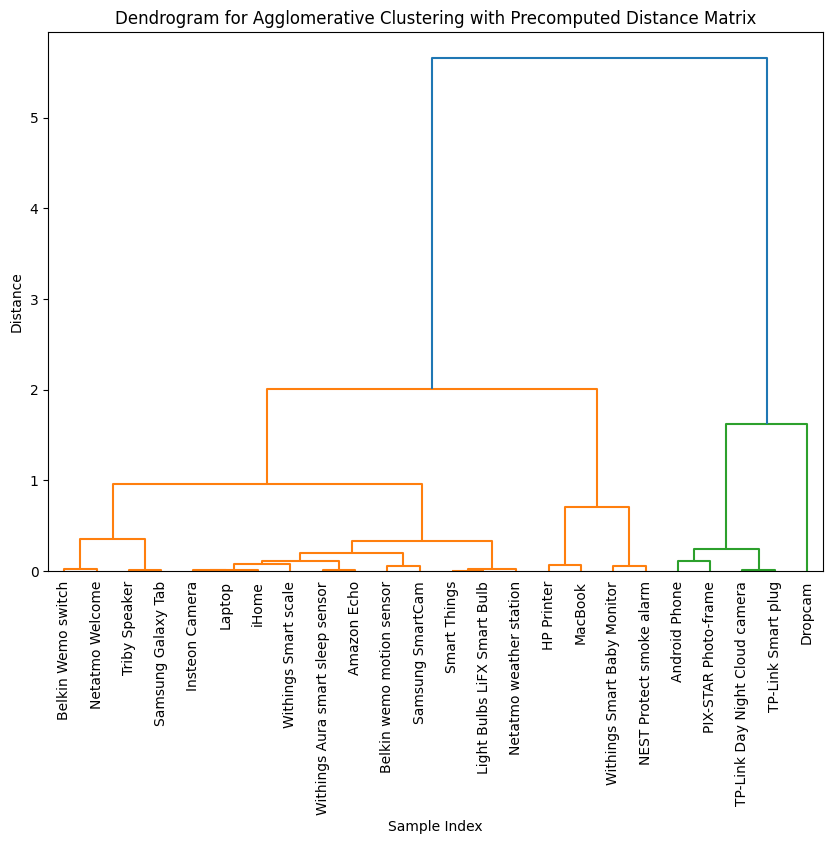

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform


# Compute the distance matrix
# dist_matrix = pairwise_distances(X, metric='euclidean')

# Convert the distance matrix to condensed form
# The linkage function expects a condensed distance matrix
condensed_dist_matrix = squareform(weighted_hamming_distance, force='tovector')

# Perform hierarchical clustering using the linkage function
Z = linkage(condensed_dist_matrix, method='complete')

# Generate and plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=classes_ordered[:24], distance_sort='descending', leaf_rotation=90)
plt.title('Dendrogram for Agglomerative Clustering with Precomputed Distance Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [104]:
# #--------------------Davies Bouldin score for hierarchical models-------------------------
# from sklearn.metrics import davies_bouldin_score
# from sklearn import metrics
# def get_Hmeans_score(
#     data, center
# ):  #--------------------- We can specify linkage and distance
#     """
#     returns the  score regarding Davies Bouldin for points to centers
#     INPUT:
#         data - the dataset you want to fit Agglomerative to
#         distance - the distance for AgglomerativeClustering
#         link - the linkage method for AgglomerativeClustering
#         center - the number of clusters you want (the k value)
#     OUTPUT:
#         score - the Davies Bouldin score for the Hierarchical model fit to the data
#     """
#     #---------------instantiate Hierarchical Clustering
    
#     # hmeans = AgglomerativeClustering(n_clusters=center, affinity=distance, linkage=link)
#     hmeans = AgglomerativeClustering(n_clusters=center, linkage='complete', affinity='precomputed')
    
#     #---------------Then fit the model to the data using the fit method
#     # model = hmeans.fit_predict(data)
#     model = hmeans.fit_predict(data)
    
# #---------------Calculate Davies Bouldin score
#     # score = davies_bouldin_score(data, model)
#     score = metrics.calinski_harabasz_score(data, model)
#     # print(metrics.calinski_harabasz_score(data, model))
#     return score

# centers = list(range(2, 15)) #------Number of Clusters in the data
# avg_scores = []
# for center in centers:
#  avg_scores.append(get_Hmeans_score(weighted_hamming_distance, center))
 
# plt.figure(figsize=(15,6))
 
# plt.plot(centers, avg_scores, marker="o", color="orange")
# plt.xlabel("K")
# plt.ylabel("Davies Bouldin score")
# plt.title("Davies Bouldin score vs. K")

In [118]:
#i.create dictionary to hold calinski harabasz values for each cluster
# from sklearn.metrics import calinski_harabasz_score
# ch = {}     
# #ii.create a loop to run KMEANS for clusters in the range of 2 to 10                                    
# for k in range (2,10) :
#     # kmeans= KMeans(n_clusters=k, random_state=1).fit(happy_2022_scaled)
#     model_average = AgglomerativeClustering(n_clusters=n_cluster, linkage='complete', affinity='precomputed')
#     #
#     clusters_average = model_average.fit_predict(weighted_hamming_distance)
#     ch[k]=calinski_harabasz_score(weighted_hamming_distance, clusters_average)
# print(ch)
    
# ch_fig = px.line(x=list(ch.keys()),
#                  y=list(ch.values()),
#                 markers=True,
#                  labels={'x':'Number of cluster',
#                            'y':'Calinski-Harabasz score'},
#                 template='simple_white',
#                 title='KMeans evaluation:Calinski-Harabasz Index ')
# ch_fig.show(renderer='iframe')

In [105]:
# import numpy as np
# from sklearn.cluster import AgglomerativeClustering
# import matplotlib.pyplot as plt
# from sklearn.metrics import pairwise_distances

# def calculate_within_cluster_sum_of_squares(X, labels):
#     n_clusters = len(set(labels))
#     cluster_k = [X[labels == k] for k in range(n_clusters)]
#     centroids = [np.mean(cluster, axis=0) for cluster in cluster_k]
#     WCSS = sum(np.sum(pairwise_distances(cluster, [centroid]) ** 2) for cluster, centroid in zip(cluster_k, centroids))
#     return WCSS

# # Range of number of clusters to evaluate
# range_n_clusters = range(1, 12)

# # List to store the within-cluster sum of squares for each number of clusters
# wcss = []

# for n_clusters in range_n_clusters:
#     clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
#     clustering_model.fit(weighted_hamming_distance)
#     labels = clustering_model.labels_
#     wcss.append(calculate_within_cluster_sum_of_squares(weighted_hamming_distance, labels))

# # Plotting the Elbow Graph
# plt.plot(range_n_clusters, wcss, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
# plt.title('Elbow Method for Optimal Number of Clusters')
# plt.show()


In [34]:
# from scipy.cluster.hierarchy import dendrogram, linkage

# linkage_data = linkage(weighted_hamming_distance, method='ward', metric='precomputed')
# dendrogram(linkage_data)
# plt.show()

In [92]:
data_to_cluster = data_to_cluster.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')
#
data_to_cluster_inliers_df = data_to_cluster_inliers_df.groupby('c_name', group_keys=False).apply(assign_clusters, clustering_result=clusters_average, classes=classes_ordered, clustering_method='Agg_Cluster')

In [93]:
data_to_cluster['c_name'].unique()

array(['Android Phone', 'Insteon Camera', 'Netatmo weather station',
       'HP Printer', 'PIX-STAR Photo-frame', 'NEST Protect smoke alarm',
       'Samsung Galaxy Tab', 'TP-Link Smart plug',
       'TP-Link Day Night Cloud camera', 'Belkin Wemo switch',
       'Withings Smart Baby Monitor', 'Laptop',
       'Withings Aura smart sleep sensor', 'Belkin wemo motion sensor',
       'Light Bulbs LiFX Smart Bulb', 'Amazon Echo', 'iHome',
       'Triby Speaker', 'Netatmo Welcome', 'Withings Smart scale',
       'Smart Things', 'Dropcam', 'MacBook', 'Samsung SmartCam'],
      dtype=object)

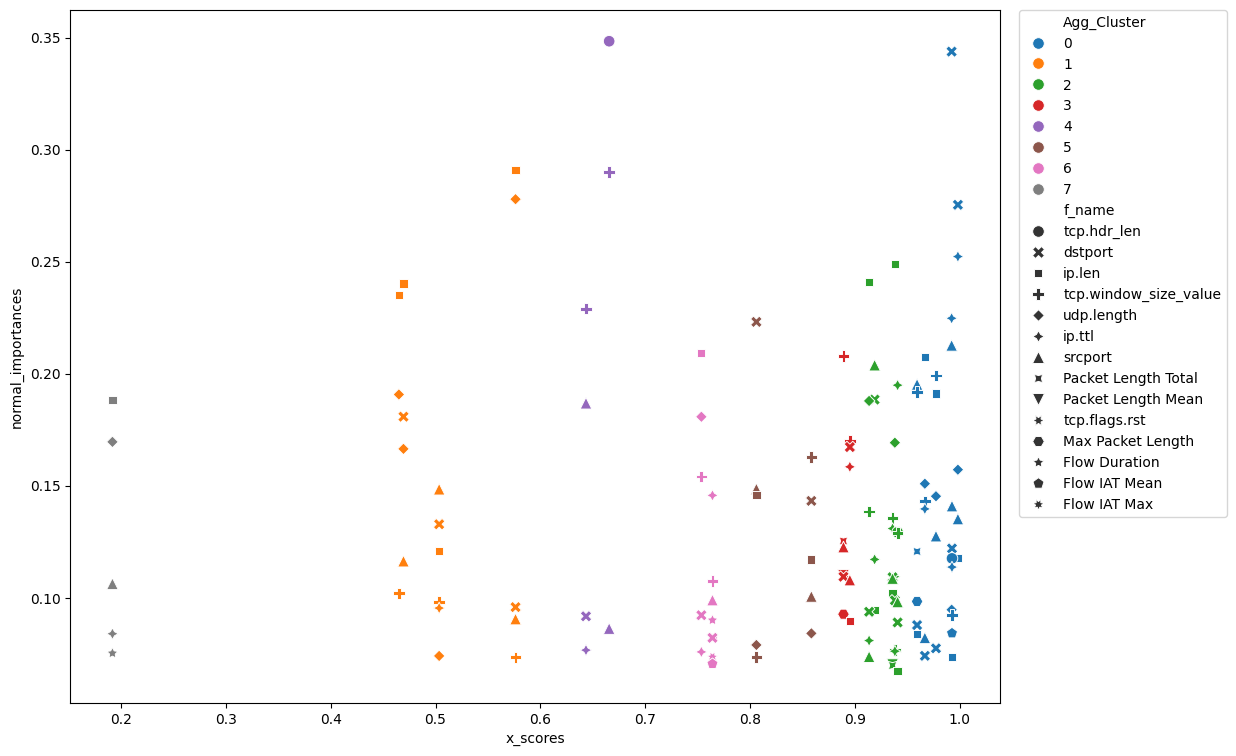

In [94]:
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
markers_dict = dict(zip(feature_names,marker_lst))

fig, ax = plt.subplots(figsize=(12,9))
sns.scatterplot(data=data_to_cluster_inliers_df, x='x_scores', y='normal_importances', ax=ax, hue='Agg_Cluster', style="f_name", s=70, palette="tab10")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.xlim(0.7, 1)
plt.show()

In [95]:
score_per_class_df

,class,f1_score,support
14,Light Bulbs LiFX Smart Bulb,99.836551,1509.0
15,Netatmo weather station,99.271827,248.0
19,Smart Things,99.239209,592.0
2,Samsung SmartCam,97.744553,13334.0
3,Amazon Echo,96.684257,4649.0
5,Belkin wemo motion sensor,95.942556,3282.0
0,Laptop,94.084491,11484.0
1,Insteon Camera,93.822807,6888.0
20,iHome,93.602732,160.0
22,Withings Smart scale,91.891892,6.0


In [96]:
cluster_info = get_statistics_of_clustering(classes, score_per_class_df, clusters_average)
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,-1,"[Blipcare Blood Pressure meter, IPhone]",-1,-1,-1,-1
1,0,"[Light Bulbs LiFX Smart Bulb, Netatmo weather station, Smart Things, Samsung SmartCam, Amazon Echo, Belkin wemo motion sensor]",-1,-1,-1,-1
2,1,"[PIX-STAR Photo-frame, Android Phone, TP-Link Smart plug, TP-Link Day Night Cloud camera]",-1,-1,-1,-1
3,2,"[Laptop, Insteon Camera, iHome, Withings Smart scale, Withings Aura smart sleep sensor]",-1,-1,-1,-1
4,3,"[Netatmo Welcome, Belkin Wemo switch]",-1,-1,-1,-1
5,4,"[MacBook, HP Printer]",-1,-1,-1,-1
6,5,"[Samsung Galaxy Tab, Triby Speaker]",-1,-1,-1,-1
7,6,"[NEST Protect smoke alarm, Withings Smart Baby Monitor]",-1,-1,-1,-1
8,7,[Dropcam],-1,-1,-1,-1


In [38]:
# # from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# cm = confusion_matrix(y_true=list(expanded_y_true), y_pred=expanded_y_pred, sample_weight=expanded_weights, labels=list(range(0, len(classes))))
# #
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# # disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=classes)
# # fig, ax = plt.subplots(figsize=(30,30))
# # disp.plot(ax=ax)
# # ax.set_xticklabels(classes, rotation=90)

# #######
# ## Dataframe ##
# cm_normalized_df = pd.DataFrame(columns=classes)

# for i in range(0, len(classes)):
#     true_label = cm_normalized[i]
#     cm_normalized_df.loc[len(cm_normalized_df.index)] = true_label
# cm_normalized_df.insert(loc=0, column='Class_Name', value=classes)

In [40]:
# columns_df = ['Class_Name']
# columns_df.extend(all_classes_in_cluster_order)
# cm_ordered_df = cm_normalized_df[columns_df]

# temp_df_to_merge = pd.DataFrame()
# temp_df_to_merge['Class_Name'] = all_classes_in_cluster_order

# cm_ordered_df = temp_df_to_merge.merge(right=cm_ordered_df, on='Class_Name')

In [44]:
# # from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # cm = confusion_matrix(y_true=list(y_test), y_pred=y_pred, labels=list(range(0, len(classes))))
# cm = cm_ordered_df[all_classes_in_cluster_order].to_numpy()
# #
# cm_normalized = []
# for cl_list in cm:
#     if np.sum(cl_list)!=0:
#         cm_normalized.append(np.array(cl_list)*100/np.sum(cl_list))
#     else:
#         cm_normalized.append(np.array(cl_list))
# cm_normalized = np.array(cm_normalized)
# # cm_normalized
# #
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=all_classes_in_cluster_order)
# fig, ax = plt.subplots(figsize=(16,22))
# disp.plot(ax=ax)
# ax.set_xticklabels(all_classes_in_cluster_order, rotation=90)


In [97]:
#### To get cluster statistics ####
for cluster in list(set(clusters_average)):
    print('\n CLUSTER: ', cluster)
    cluster_df = data_to_cluster_inliers_df[data_to_cluster_inliers_df['Agg_Cluster'] == cluster]
    feat_importances_dict = cluster_df.groupby('f_name')['normal_importances'].mean().to_dict()
    feat_importance_df = pd.DataFrame()
    feat_importance_df['f_name'] = feat_importances_dict.keys()
    feat_importance_df['f_imp'] = feat_importances_dict.values()
    feat_importance_df = feat_importance_df.sort_values(by='f_imp', ascending=False)
    print('Number of Classes: ', len(cluster_df['c_name'].unique()))
    print('Number of Features: ', len(cluster_df['f_name'].unique()))
    print('------')
    print('Classes: ', cluster_df['c_name'].unique())
    print('Features: ', feat_importance_df['f_name'].to_list())
    print('Class Score: ', cluster_df['x_scores'].unique())
    print('------')
    #
    cluster_info.loc[cluster_info['Cluster'] == cluster, 'Feature List'] = str(feat_importance_df['f_name'].to_list())


 CLUSTER:  0
Number of Classes:  6
Number of Features:  10
------
Classes:  ['Smart Things' 'Light Bulbs LiFX Smart Bulb' 'Amazon Echo'
 'Samsung SmartCam' 'Belkin wemo motion sensor' 'Netatmo weather station']
Features:  ['ip.ttl', 'dstport', 'tcp.window_size_value', 'srcport', 'udp.length', 'ip.len', 'Packet Length Total', 'tcp.hdr_len', 'Max Packet Length', 'Flow IAT Mean']
Class Score:  [0.99239209 0.99836551 0.96684257 0.97744553 0.95942556 0.99271827]
------

 CLUSTER:  1
Number of Classes:  4
Number of Features:  6
------
Classes:  ['PIX-STAR Photo-frame' 'TP-Link Smart plug'
 'TP-Link Day Night Cloud camera' 'Android Phone']
Features:  ['ip.len', 'udp.length', 'dstport', 'srcport', 'ip.ttl', 'tcp.window_size_value']
Class Score:  [0.57633795 0.46942512 0.46507257 0.50347747]
------

 CLUSTER:  2
Number of Classes:  5
Number of Features:  10
------
Classes:  ['Insteon Camera' 'Withings Aura smart sleep sensor'
 'Withings Smart scale' 'Laptop' 'iHome']
Features:  ['udp.length', 

In [98]:
type(cluster_info.style.set_properties(**{'text-align': 'left'}))
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,-1,"[Blipcare Blood Pressure meter, IPhone]",-1,-1,-1,-1
1,0,"[Light Bulbs LiFX Smart Bulb, Netatmo weather station, Smart Things, Samsung SmartCam, Amazon Echo, Belkin wemo motion sensor]","['ip.ttl', 'dstport', 'tcp.window_size_value', 'srcport', 'udp.length', 'ip.len', 'Packet Length Total', 'tcp.hdr_len', 'Max Packet Length', 'Flow IAT Mean']",-1,-1,-1
2,1,"[PIX-STAR Photo-frame, Android Phone, TP-Link Smart plug, TP-Link Day Night Cloud camera]","['ip.len', 'udp.length', 'dstport', 'srcport', 'ip.ttl', 'tcp.window_size_value']",-1,-1,-1
3,2,"[Laptop, Insteon Camera, iHome, Withings Smart scale, Withings Aura smart sleep sensor]","['udp.length', 'ip.len', 'tcp.hdr_len', 'srcport', 'ip.ttl', 'tcp.window_size_value', 'dstport', 'tcp.flags.rst', 'Packet Length Mean', 'Packet Length Total']",-1,-1,-1
4,3,"[Netatmo Welcome, Belkin Wemo switch]","['tcp.window_size_value', 'ip.ttl', 'dstport', 'Packet Length Total', 'srcport', 'Packet Length Mean', 'ip.len', 'Max Packet Length']",-1,-1,-1
5,4,"[MacBook, HP Printer]","['tcp.hdr_len', 'tcp.window_size_value', 'srcport', 'dstport', 'ip.ttl']",-1,-1,-1
6,5,"[Samsung Galaxy Tab, Triby Speaker]","['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']",-1,-1,-1
7,6,"[NEST Protect smoke alarm, Withings Smart Baby Monitor]","['udp.length', 'ip.len', 'tcp.window_size_value', 'ip.ttl', 'srcport', 'Flow Duration', 'dstport', 'Flow IAT Max', 'Flow IAT Mean']",-1,-1,-1
8,7,[Dropcam],"['ip.len', 'udp.length', 'srcport', 'ip.ttl', 'Flow Duration']",-1,-1,-1


In [99]:
cluster_info.to_csv('cluster_info_W_24CL_8cluster_DiffHammingDistance.csv')

In [83]:
# density_df.drop_duplicates('c_name', keep='first').sort_values(by='x_scores', ascending=False)[['c_name', 'x_scores']]

In [84]:
# cluster = ['Netatmo weather station', 'Light Bulbs LiFX Smart Bulb', 'Smart Things']
# feats_to_use = ['dstport', 'ip.ttl', 'srcport', 'udp.length', 'tcp.hdr_len', 'ip.len', 'tcp.window_size_value', 'Flow IAT Mean']
# density_inliers_df[(density_inliers_df['c_name'].isin(cluster) & (density_inliers_df['f_name'].isin(feats_to_use)))].groupby(by='c_name')['normal_importances'].sum()

In [112]:
# left_v = density_df.drop_duplicates('c_name', keep='first').sort_values(by='x_scores', ascending=False).reset_index()[['c_name', 'x_scores']]
# left_v = left_v.rename(columns={'c_name': 'class'})
# score_per_class_df = pd.merge(right=score_per_class_df, left=left_v, on='class')

## Model analysis results - per cluster

In [29]:
# list of all extracted features
feats_all = ["ip.len",'ip.hdr_len',"ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst", "tcp.flags.reset",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length", 'UDP Len Min', 'UDP Len Max', 'UDP Len Total',\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count", "Packet Count"]

feats_sizes = [16, 16, 8, 1, 1, 1, 1, 1, 1,
               1, 8, 16, 16, 16, 4, 16, 16, 16, 16,
                16, 16, 16, 16,
                32, 32, 32, 32,
                8, 8, 8, 8, 8, 8, 16]

feats_size_dict = {}
for f_ind in range(0, len(feats_all)):
    feats_size_dict[feats_all[f_ind]] = feats_sizes[f_ind]
    
available_TCAM_table = 24*12

In [30]:
def calculate_score(support_total, mult_score_support, score):
    macro_score = np.mean(np.array(score))
    weighted_score = np.sum(mult_score_support)/support_total
    
    return macro_score, weighted_score

def concat_csvs(path, dir_entries, use_case):
    d_frames = []
    count = 2
    
    for dir_csv in dir_entries:
        f_name = path + dir_csv
        # print(f_name)
        i_df = pd.read_csv(f_name, sep=';')
        # if use_case == 'planter':
        #     i_df['N_Leaves'] = 500
        #     i_df['New_Macro_F1'] = i_df['macro']
        #     i_df['New_Weighted_F1'] = i_df['weighted']
        #     i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>8))]
        # if use_case == 'flowrest':
        #     i_df['N_Leaves'] = 500
        #     i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>5))]
        #     i_df = i_df.loc[~((i_df['tree'] == 3) & (i_df['no_feats']>8))]
        #     i_df = i_df[i_df['tree']  != 2]
        #     i_df = i_df[i_df['tree']!= 4]
        if use_case == 'jewel':
            i_df = i_df.loc[~((i_df['tree'] == 5) & (i_df['no_feats']>4))]
            i_df = i_df.loc[~((i_df['tree'] == 3) & (i_df['no_feats']>7))]
            i_df = i_df[i_df['tree']  != 2]
            i_df = i_df[i_df['tree']!= 4]

        i_df = i_df[['depth','tree', 'no_feats', 'New_Macro_F1', 'New_Weighted_F1', 'N_Leaves', 'feats']]
        # i_df = i_df[i_df['depth'] > 8]
        i_df = i_df[i_df['tree'] < 6]
        # i_df = i_df[i_df['tree']  != 2]
        # i_df = i_df[i_df['tree']!= 4]
        i_df = i_df[i_df['no_feats'] < 11]
        i_df = i_df[i_df['N_Leaves'] > 120]
        i_df['N'] = count
        i_df['F1_score'] = i_df.apply(lambda x: 0.5*(x['New_Macro_F1'] + x['New_Weighted_F1']), axis=1)
        # i_df['F1_score'] = i_df['New_Macro_F1']
        d_frames.append(i_df)
        # print(len(i_df))
        count = count + 1
        
    # print(d_frames)
    return pd.concat(d_frames)

def calculate_tcam_for_codetables(models_df):
    
    models_df['tcam_codetable'] = models_df.apply(lambda x: (int(x['N_Leaves']/44) + 1)*x['tree'], axis=1)

    return models_df

def calculate_tcam_for_featable(models_df):
    feats_for_all_models = list(models_df['feats'])
    tcam_usage_per_model = []
    for feats_in_models in feats_for_all_models:
        feats_in_models_list = feats_in_models[2:][:-2].split('\', \'')
        tcam_usage = 0
        # print(feats_in_models_list)
        for feat in feats_in_models_list:
            # print(feat)
            bit_length = feats_size_dict[feat]
            tcam_usage = tcam_usage + int((2*bit_length)/44) +1
            # print(bit_length, tcam_usage)
        
        tcam_usage_per_model.append(tcam_usage) 
    models_df['tcam_feature_table'] = tcam_usage_per_model
    return models_df

def total_tcam_usage(models_df):
    models_df['total_tcam_tbl_usage'] = models_df.apply(lambda x: x['tcam_feature_table'] + x['tcam_codetable'], axis=1)
    models_df['total_tcam_usage'] = models_df.apply(lambda x: x['total_tcam_tbl_usage']/available_TCAM_table, axis=1)
    # models_df['success_score'] = models_df.apply(lambda x: 0.5*(x['F1_score'] + (1-x['total_tcam_usage']) ), axis=1)
    # models_df['penalty'] = np.where(models_df['tree'] == 5, 1, 0)
    models_df['success_score'] = models_df.apply(lambda x: (0.5*x['Avg_F1_score'] + 0.5*(1-x['total_tcam_usage'])), axis=1)
    return models_df

def plot_scatter(x, y, x1, y1, xlabel, ylabel, name, outfile):

    font = {'family': 'sans-serif',
            'weight': 'normal',
            'size': 19}
    plt.rc('font', **font)

    plt.figure(figsize=(5, 4))
    
    if name == 'jewel':
        plt.scatter(x, y, c='#6E7E99', alpha=0.28, edgecolors='none')
    else:
        plt.scatter(x, y, c='#6E7E99', alpha=0.5, edgecolors='none')
    # plt.scatter(x1, y1, c='#E06B5A', alpha=1, edgecolors='none')
    plt.scatter(x1, y1, c='#EE4B2B', alpha=1, edgecolors='none', s=200)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0,25)
    plt.ylim(0,105)
    plt.xticks([0, 5, 10, 15, 20, 25])
    
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0.1)
    
    plt.show()

In [31]:
def select_best_models_per_cluster(n_values, n_of_clusters, total_n_classes, cluster_info, score_per_class_df, type_of_run, folder_name, use_case):
    
    ### For each cluster 
    for cl in range(0, n_of_clusters):
        d_frames = []
        ### For each value of N
        for nd in n_values:
            #### Get the related model analysis file and concat with the nd value
            if type_of_run=="With_Others":
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_Ordered.csv"
            else:
                f_name = folder_name + "/" + use_case + "_models_"+str(nd)+"pkts_PF_WB_" + str(total_n_classes) + "CL_Cluster" + str(cl) + "_WithoutOther.csv"
            model_analysis_for_nth = pd.read_csv(f_name, sep=';')
            model_analysis_for_nth['N'] = nd
            #
            model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (0.5)*(x['Macro_f1_FL'] + x['Weighted_f1_FL']), axis=1) ###?? MICRO ? 
            # model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (1/3)*(x['Macro_f1_FL'] + x['Weighted_f1_FL'] + x['Micro_f1_FL']), axis=1) ###?? MICRO ? 
            # model_analysis_for_nth['Avg_F1_score'] = model_analysis_for_nth.apply(lambda x: (x['Macro_f1_FL']), axis=1) ###?? MICRO ? 
            d_frames.append(model_analysis_for_nth)
        models_for_cluster = pd.concat(d_frames)
        models_for_cluster = models_for_cluster.reset_index()
        
        #### Calculate TOTAL TCAM usage and calculate SUCCESS SCORE
        models_with_tcam_info = calculate_tcam_for_codetables(models_for_cluster)
        models_with_tcam_info = calculate_tcam_for_featable(models_with_tcam_info)
        models_with_tcam_info = total_tcam_usage(models_with_tcam_info)
        ####
        
        #### ORDER in terms of SUCCESS SCORE and choose the BEST
        # print(models_with_tcam_info.sort_values('success_score', ascending=0).head(1))
        chosen_model_tcam_usage = models_with_tcam_info.sort_values('success_score', ascending=0)['total_tcam_usage'].to_list()[0]*100
        chosen_model_avg_f1_score = models_with_tcam_info.sort_values('success_score', ascending=0)['Avg_F1_score'].to_list()[0]*100
        chosen_model_index = models_with_tcam_info.sort_values('success_score', ascending=0).head(1).index.to_list()[0]
        # print(chosen_model_index, chosen_model_tcam_usage, chosen_model_avg_f1_score)
        ####
        
        chosen_model = models_with_tcam_info.loc[chosen_model_index]
        
        #### Store the information of chosen model
        cl_report = convert_str_to_dict(chosen_model['cl_report_FL'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Depth_' + type_of_run] = int(chosen_model['depth'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Tree_' + type_of_run] = int(chosen_model['tree'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Feats_' + type_of_run] = int(chosen_model['no_feats'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Leaves_' + type_of_run] = int(chosen_model['N_Leaves'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'N_' + type_of_run] = int(chosen_model['N'])
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Macro_f1_FL_' + type_of_run] = chosen_model['Macro_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Weighted_f1_FL_' + type_of_run] = chosen_model['Weighted_f1_FL']*100
        cluster_info.loc[cluster_info['Cluster'] == cl, 'Micro_f1_FL_' + type_of_run] = chosen_model['Micro_f1_FL']*100
        #
        result_dict = {}
        for d_keys in cl_report.keys():
            if (d_keys != 'accuracy') and (d_keys != 'micro avg'):
                result_dict[d_keys] = cl_report[d_keys]['f1-score']
                if d_keys in classes:
                    df_col = 'Cluster_F1_Score_' + type_of_run
                    score_per_class_df.loc[score_per_class_df['class'] == d_keys, df_col] = cl_report[d_keys]['f1-score']*100
                    score_per_class_df.loc[score_per_class_df['class'] == d_keys, 'Cluster'] = cl
        ####
        
        #### PLOT the chosen model (SCATTER) ####
        tcam_usage = list(models_with_tcam_info['total_tcam_usage'])
        weighted_scores = list(models_with_tcam_info['Avg_F1_score'])
        
        x = [i * 100 for i in tcam_usage]
        y = [i * 100 for i in weighted_scores]

        # plot_scatter(x, y, chosen_model_tcam_usage, chosen_model_avg_f1_score, "Usage of TCAM Resources [%]", "", 'jewel', 'model_analysis_results/unibs_jewel_Success.pdf')
        ####

    return cluster_info, score_per_class_df

In [90]:
### Initialize dataframes to use for statistics
total_n_classes = 24
n_of_clusters = 8
cluster_info = pd.read_csv('/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_info_W_'+str(total_n_classes)+'CL_'+str(n_of_clusters)+'cluster.csv', sep=',')
# print(cluster_info)
cluster_info = cluster_info[['Cluster', 'Class List', 'Feature List']]
# cluster_info['N'] = [-1]*len(cluster_info)
score_per_class_df['Cluster'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_With_Ordered'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_With_Others'] = [-1]*len(score_per_class_df)
score_per_class_df['Cluster_F1_Score_Without_Others'] = [-1]*len(score_per_class_df)

In [101]:
cluster_info, score_per_class_df = select_best_models_per_cluster([2,3], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "With_Others", '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness', 'unsw')
# cluster_info, score_per_class_df = select_best_models_per_cluster([2,3], n_of_clusters, total_n_classes, cluster_info, score_per_class_df, "Without_Others", '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/Proportional_fairness/24CL', 'unsw')

In [104]:
cluster_info[['Cluster', 'Class List', 'Feature List', 'Depth_With_Others', 'Tree_With_Others', 'Feats_With_Others', 'Leaves_With_Others', 'N_With_Others']]


,Cluster,Class List,Feature List,Depth_With_Others,Tree_With_Others,Feats_With_Others,Leaves_With_Others,N_With_Others
0,-1,"['Blipcare Blood Pressure meter', 'IPhone']",-1,NaN,NaN,NaN,NaN,NaN
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...","['ip.len', 'udp.length', 'dstport', 'srcport',...",14.0,2.0,6.0,261.0,2.0
2,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...","['udp.length', 'ip.len', 'tcp.window_size_valu...",13.0,1.0,7.0,437.0,3.0
3,2,"['MacBook', 'HP Printer']","['tcp.hdr_len', 'tcp.window_size_value', 'srcp...",10.0,1.0,5.0,129.0,3.0
4,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...","['dstport', 'ip.ttl', 'srcport', 'udp.length',...",11.0,1.0,3.0,129.0,2.0
5,4,"['Netatmo Welcome', 'Belkin Wemo switch']","['tcp.window_size_value', 'ip.ttl', 'dstport',...",17.0,1.0,7.0,173.0,3.0
6,5,"['NEST Protect smoke alarm', 'Withings Smart B...","['udp.length', 'ip.len', 'tcp.window_size_valu...",10.0,1.0,7.0,129.0,2.0
7,6,"['Samsung Galaxy Tab', 'Triby Speaker']","['dstport', 'ip.len', 'srcport', 'tcp.window_s...",16.0,1.0,5.0,437.0,2.0
8,7,['Dropcam'],"['ip.len', 'udp.length', 'srcport', 'ip.ttl', ...",8.0,4.0,5.0,41.0,2.0


In [102]:
cluster_info[['Cluster', 'Class List', 'Feature List', 'Depth_Ordered', 'Tree_Ordered', 'Feats_Ordered', 'Leaves_Ordered', 'N_Ordered']]

,Cluster,Class List,Feature List,Depth_Ordered,Tree_Ordered,Feats_Ordered,Leaves_Ordered,N_Ordered
0,-1,"['Blipcare Blood Pressure meter', 'IPhone']",-1,NaN,NaN,NaN,NaN,NaN
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...","['ip.len', 'udp.length', 'dstport', 'srcport',...",17.0,1.0,6.0,129.0,2.0
2,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...","['udp.length', 'ip.len', 'tcp.window_size_valu...",14.0,1.0,5.0,481.0,2.0
3,2,"['MacBook', 'HP Printer']","['tcp.hdr_len', 'tcp.window_size_value', 'srcp...",10.0,2.0,4.0,41.0,2.0
4,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...","['dstport', 'ip.ttl', 'srcport', 'udp.length',...",12.0,2.0,3.0,41.0,2.0
5,4,"['Netatmo Welcome', 'Belkin Wemo switch']","['tcp.window_size_value', 'ip.ttl', 'dstport',...",14.0,1.0,4.0,129.0,2.0
6,5,"['NEST Protect smoke alarm', 'Withings Smart B...","['udp.length', 'ip.len', 'tcp.window_size_valu...",11.0,2.0,6.0,85.0,2.0
7,6,"['Samsung Galaxy Tab', 'Triby Speaker']","['dstport', 'ip.len', 'srcport', 'tcp.window_s...",11.0,1.0,5.0,85.0,2.0
8,7,['Dropcam'],"['ip.len', 'udp.length', 'srcport', 'ip.ttl', ...",9.0,3.0,4.0,41.0,2.0


In [103]:
cluster_info[['Cluster', 'Class List', 'Feature List', 'Depth_Without_Others', 'Tree_Without_Others', 'Feats_Without_Others', 'Leaves_Without_Others', 'N_Without_Others']]

,Cluster,Class List,Feature List,Depth_Without_Others,Tree_Without_Others,Feats_Without_Others,Leaves_Without_Others,N_Without_Others
0,-1,"['Blipcare Blood Pressure meter', 'IPhone']",-1,NaN,NaN,NaN,NaN,NaN
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...","['ip.len', 'udp.length', 'dstport', 'srcport',...",14.0,1.0,6.0,129.0,2.0
2,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...","['udp.length', 'ip.len', 'tcp.window_size_valu...",16.0,1.0,6.0,305.0,2.0
3,2,"['MacBook', 'HP Printer']","['tcp.hdr_len', 'tcp.window_size_value', 'srcp...",19.0,2.0,1.0,41.0,2.0
4,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...","['dstport', 'ip.ttl', 'srcport', 'udp.length',...",9.0,1.0,3.0,41.0,2.0
5,4,"['Netatmo Welcome', 'Belkin Wemo switch']","['tcp.window_size_value', 'ip.ttl', 'dstport',...",8.0,1.0,1.0,41.0,3.0
6,5,"['NEST Protect smoke alarm', 'Withings Smart B...","['udp.length', 'ip.len', 'tcp.window_size_valu...",11.0,1.0,2.0,41.0,2.0
7,6,"['Samsung Galaxy Tab', 'Triby Speaker']","['dstport', 'ip.len', 'srcport', 'tcp.window_s...",9.0,1.0,5.0,41.0,2.0
8,7,['Dropcam'],"['ip.len', 'udp.length', 'srcport', 'ip.ttl', ...",5.0,1.0,1.0,41.0,2.0


In [105]:
score_per_class_df[['Cluster', 'class', 'f1_score', 'Cluster_F1_Score_Ordered', 'Cluster_F1_Score_With_Others', 'Cluster_F1_Score_Without_Others', 'support']]

,Cluster,class,f1_score,Cluster_F1_Score_Ordered,Cluster_F1_Score_With_Others,Cluster_F1_Score_Without_Others,support
14,3,Light Bulbs LiFX Smart Bulb,99.836551,98.606503,99.312751,99.933687,1509.0
15,3,Netatmo weather station,99.271827,98.387097,98.989899,99.396378,248.0
19,3,Smart Things,99.239209,99.131896,99.453092,99.746835,592.0
2,1,Samsung SmartCam,97.744553,98.735189,96.349089,99.316582,13334.0
3,1,Amazon Echo,96.684257,94.656354,91.205089,95.817408,4649.0
5,1,Belkin wemo motion sensor,95.942556,99.440554,95.869581,99.923815,3282.0
0,1,Laptop,94.084491,91.136743,87.828910,98.114805,11484.0
1,1,Insteon Camera,93.822807,94.222632,91.481991,97.554373,6888.0
20,1,iHome,93.602732,84.692324,79.624948,91.900826,160.0
22,1,Withings Smart scale,91.891892,79.827530,61.868013,79.911045,6.0


In [106]:
##### SCORE CALCULATION #####
### With Unsuccessful Classes
score_calc_df = score_per_class_df[score_per_class_df['f1_score']>5]
score_calc_df['mult_With_Others'] = score_calc_df['Cluster_F1_Score_With_Others']*score_calc_df['support']
score_calc_df['mult_Without_Others'] = score_calc_df['Cluster_F1_Score_Without_Others']*score_calc_df['support']
##
print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_With_Others'], score_calc_df['Cluster_F1_Score_With_Others']))
print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_Without_Others'], score_calc_df['Cluster_F1_Score_Without_Others']))


After the clustering with ALL:  (80.00619375933296, 86.85244875592429)
After the clustering with ALL:  (95.00996348322974, 98.21686732602852)


In [97]:
##### SCORE CALCULATION #####
### With Unsuccessful Classes
score_calc_df = score_per_class_df[score_per_class_df['f1_score']>5]
score_calc_df['mult_Ordered'] = score_calc_df['Cluster_F1_Score_Ordered']*score_calc_df['support']
# score_calc_df['mult_Without_Others'] = score_calc_df['Cluster_F1_Score_Without_Others']*score_calc_df['support']
##
print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_Ordered'], score_calc_df['Cluster_F1_Score_Ordered']))
# print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_Without_Others'], score_calc_df['Cluster_F1_Score_Without_Others']))


After the clustering with ALL:  (88.5262869658846, 92.22698930663715)


### Metric to rate clusters - ORDER of CLUSTERS

In [67]:
cluster_rating = cluster_info.copy()
cluster_rating = cluster_rating[cluster_rating['Cluster'] != -1]
cluster_rating['Average_F1_With_Others'] = (cluster_rating['Macro_f1_FL_With_Others'] + cluster_rating['Weighted_f1_FL_With_Others'] + cluster_rating['Micro_f1_FL_With_Others'])*(1/3)
cluster_rating['Average_F1_Without_Others'] = (cluster_rating['Macro_f1_FL_Without_Others'] + cluster_rating['Weighted_f1_FL_Without_Others'] + cluster_rating['Micro_f1_FL_Without_Others'])*(1/3)
cluster_rating = cluster_rating[['Cluster', 'Class List', 'Average_F1_With_Others', 'Average_F1_Without_Others']]
##
score_per_class_CL_df = score_per_class_df.copy()
score_per_class_CL_df['F1_score_difference'] = score_per_class_CL_df['Cluster_F1_Score_Without_Others'] - score_per_class_CL_df['Cluster_F1_Score_With_Others']
##
cluster_list = cluster_rating['Class List'].to_list()
avg_score_change = []
total_n_samples = []
n_of_classes = []
for cl in cluster_list:
    cl_list = cl[2:-2].split("', '")
    score_per_class = score_per_class_CL_df[score_per_class_CL_df['class'].isin(cl_list)]
    avg_score_change.append(np.mean(score_per_class['F1_score_difference'].to_list()))
    total_n_samples.append(int(np.sum(score_per_class['support'].to_list())))
    n_of_classes.append(int(len(score_per_class)))
cluster_rating['Avg_F1_score_change'] = avg_score_change
cluster_rating['Support'] = total_n_samples
cluster_rating['Number_of_classes'] = n_of_classes


In [68]:
cluster_rating

,Cluster,Class List,Average_F1_With_Others,Average_F1_Without_Others,Avg_F1_score_change,Support,Number_of_classes
1,0,"['PIX-STAR Photo-frame', 'Android Phone', 'TP-...",80.910531,91.523197,49.496954,2197,4
2,1,"['Samsung SmartCam', 'Amazon Echo', 'Belkin we...",89.883277,97.132195,7.750711,40789,8
3,2,"['MacBook', 'HP Printer']",92.988693,92.200457,16.793275,2067,2
4,3,"['Light Bulbs LiFX Smart Bulb', 'Netatmo weath...",99.500891,99.783961,1.454577,2349,3
5,4,"['Netatmo Welcome', 'Belkin Wemo switch']",95.800459,99.116202,12.686239,3848,2
6,5,"['NEST Protect smoke alarm', 'Withings Smart B...",95.723686,99.604148,14.732262,1795,2
7,6,"['Samsung Galaxy Tab', 'Triby Speaker']",89.219007,97.760473,22.773399,8110,2
8,7,['Dropcam'],97.617713,100.000000,14.286129,3,1


#### Previous approach

In [189]:
##### >70
cluster_id = 5
model_analysis_CL = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/cluster_model_analysis_results/unsw_models_2pkts_PF_W_Both_Cluster5.csv'])
model_analysis_CL[(model_analysis_CL['tree']<3) ][['depth', 'tree', 'no_feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'Micro_f1_FL', 'feats', 'cl_report_FL']].sort_values(by='Macro_f1_FL', ascending=False).head(10)

,depth,tree,no_feats,Macro_f1_FL,Weighted_f1_FL,Micro_f1_FL,feats,cl_report_FL
62,11,1,9,0.894747,0.988648,0.989602,"['ip.len', 'udp.length', 'tcp.window_size_value', 'dstport', 'Flow Duration', 'srcport', 'ip.ttl', 'Flow IAT Mean', 'Flow IAT Max']","{'Other': {'precision': 0.9899656563008522, 'recall': 0.9994178359147455, 'f1-score': 0.994669290985445, 'support': 59366.99999991171}, 'Withings Smart Baby Monitor': {'precision': 0.9717072388008612, 'recall': 0.66287081972371, 'f1-score': 0.7881133244830072, 'support': 1772.999999999946}, 'NEST Protect smoke alarm': {'precision': 0.981711777615216, 'recall': 0.8333333333333328, 'f1-score': 0.9014576476120103, 'support': 22.000000000000092}, 'accuracy': 0.9896020725525554, 'macro avg': {'precision': 0.9811282242389764, 'recall': 0.8318739963239294, 'f1-score': 0.8947467543601543, 'support': 61161.99999991166}, 'weighted avg': {'precision': 0.9894334016401379, 'recall': 0.9896020725524561, 'f1-score': 0.9886479969668786, 'support': 61161.99999991166}}"
51,10,1,7,0.893046,0.988967,0.989919,"['ip.len', 'tcp.window_size_value', 'Flow Duration', 'dstport', 'udp.length', 'srcport', 'ip.ttl']","{'Other': {'precision': 0.9900152169033168, 'recall': 0.999696510053895, 'f1-score': 0.9948323104593927, 'support': 59366.99999991171}, 'Withings Smart Baby Monitor': {'precision': 0.9856303382062749, 'recall': 0.6644689357730362, 'f1-score': 0.7937955639652654, 'support': 1772.999999999946}, 'NEST Protect smoke alarm': {'precision': 0.956112852664577, 'recall': 0.8333333333333328, 'f1-score': 0.8905109489051093, 'support': 22.000000000000092}, 'accuracy': 0.9899188952097933, 'macro avg': {'precision': 0.9772528025913895, 'recall': 0.8324995930534214, 'f1-score': 0.8930462744432557, 'support': 61161.99999991166}, 'weighted avg': {'precision': 0.9898759107664489, 'recall': 0.9899188952098961, 'f1-score': 0.9889670146631664, 'support': 61161.99999991166}}"
251,11,2,9,0.892602,0.989944,0.990709,"['ip.len', 'tcp.window_size_value', 'udp.length', 'dstport', 'Flow Duration', 'ip.ttl', 'srcport', 'Flow IAT Max', 'Flow IAT Mean']","{'Other': {'precision': 0.9909394097056033, 'recall': 0.9995671018104255, 'f1-score': 0.9952345577355199, 'support': 59366.99999991171}, 'Withings Smart Baby Monitor': {'precision': 0.9817454090509131, 'recall': 0.695666478661455, 'f1-score': 0.8143108757717464, 'support': 1772.999999999946}, 'NEST Protect smoke alarm': {'precision': 0.8729332536916513, 'recall': 0.8636363636363629, 'f1-score': 0.8682599227729269, 'support': 22.000000000000092}, 'accuracy': 0.990708557598711, 'macro avg': {'precision': 0.9485393574827227, 'recall': 0.8529566480360812, 'f1-score': 0.8926017854267311, 'support': 61161.99999991166}, 'weighted avg': {'precision': 0.9906304417419478, 'recall': 0.9907085575985991, 'f1-score': 0.9899441628810122, 'support': 61161.99999991166}}"
79,13,1,8,0.892556,0.988970,0.989874,"['ip.len', 'tcp.window_size_value', 'dstport', 'Flow Duration', 'udp.length', 'srcport', 'ip.ttl', 'Flow IAT Mean']","{'Other': {'precision': 0.9902107938945001, 'recall': 0.9994483060885133, 'f1-score': 0.9948081062096207, 'support': 59366.99999991171}, 'Withings Smart Baby Monitor': {'precision': 0.9739749127664726, 'recall': 0.6712291944670388, 'f1-score': 0.7947468563358656, 'support': 1772.999999999946}, 'NEST Protect smoke alarm': {'precision': 0.9506044578768404, 'recall': 0.8333333333333328, 'f1-score': 0.8881143563045963, 'support': 22.000000000000092}, 'accuracy': 0.9898739459578304, 'macro avg': {'precision': 0.9715967215126043, 'recall': 0.8346702779629617, 'f1-score': 0.8925564396166942, 'support': 61161.99999991166}, 'weighted avg': {'precision': 0.9897258922131877, 'recall': 0.9898739459579369, 'f1-score': 0.9889702353335116, 'support': 61161.99999991166}}"
258,12,2,7,0.883644,0.989704,0.990467,"['ip.len', 'udp.length', 'tcp.window_size_value', 'dstport', 'Flow Duration', 'ip.ttl', 'srcport']","{'Other': {'precision': 0.9909084174144307, 'recall': 0.9993479244673014, 'f1-sco

In [190]:
chosen_model = model_analysis_CL.loc[62]
cl_report = convert_str_to_dict(chosen_model['cl_report_FL'])
cluster_info.loc[cluster_info['Cluster'] == cluster_id, 'Depth'] = int(chosen_model['depth'])
cluster_info.loc[cluster_info['Cluster'] == cluster_id, 'Tree'] = chosen_model['tree']
cluster_info.loc[cluster_info['Cluster'] == cluster_id, 'Feats'] = chosen_model['no_feats']

In [191]:
result_dict = {}
for d_keys in cl_report.keys():
    if (d_keys != 'accuracy') and (d_keys != 'micro avg'):
        result_dict[d_keys] = cl_report[d_keys]['f1-score']
        if d_keys in classes:
            score_per_class_df.loc[score_per_class_df['class'] == d_keys, 'Cluster_F1_Score'] = cl_report[d_keys]['f1-score']*100
result_dict

{'Other': 0.994669290985445,
 'Withings Smart Baby Monitor': 0.7881133244830072,
 'NEST Protect smoke alarm': 0.9014576476120103,
 'macro avg': 0.8947467543601543,
 'weighted avg': 0.9886479969668786}

In [192]:
score_per_class_df.loc[score_per_class_df['class'] == 'Blipcare Blood Pressure meter', 'f1_score'] = 1
score_per_class_df.loc[score_per_class_df['class'] == 'Cluster', 'f1_score'] = -1

In [70]:
score_per_class_df[['class', 'f1_score', 'Cluster_F1_Score', 'Cluster', 'support']]

,class,f1_score,Cluster_F1_Score,Cluster,support
14,Light Bulbs LiFX Smart Bulb,99.836551,-1,3,1509.0
15,Netatmo weather station,99.271827,-1,3,248.0
19,Smart Things,99.239209,-1,3,592.0
2,Samsung SmartCam,97.744553,-1,1,13334.0
3,Amazon Echo,96.684257,-1,1,4649.0
5,Belkin wemo motion sensor,95.942556,-1,1,3282.0
0,Laptop,94.084491,-1,1,11484.0
1,Insteon Camera,93.822807,-1,1,6888.0
20,iHome,93.602732,-1,1,160.0
22,Withings Smart scale,91.891892,-1,1,6.0


In [121]:
# score_vis_df = score_per_class_df[['class', 'f1_score', 'x_scores', 'Cluster_F1_Score', 'Cluster', 'support']]
# score_vis_df = score_vis_df.rename(columns={'x_scores': '2_models_f1', 'f1_score': '1_model_f1'})
# score_vis_df['2_models_f1'] = score_vis_df['2_models_f1']*100
# score_vis_df.sort_values(by='1_model_f1', ascending=False)

In [245]:
score_per_class_df[['class', 'f1_score', 'Cluster_F1_Score', 'Cluster', 'support']].to_csv('score_17CL_Weighted_Both.csv')

In [89]:
cluster_info

,Cluster,Class List,Feature List,Depth,Tree,Feats
0,-1,"[MacBook, HP Printer, PIX-STAR Photo-frame, Android Phone, TP-Link Smart plug, TP-Link Day Night Cloud camera, Dropcam, Blipcare Blood Pressure meter, IPhone]",-1,-1,-1,-1
1,0,"[Amazon Echo, Laptop, Insteon Camera, iHome, Withings Smart scale, Withings Aura smart sleep sensor]","['udp.length', 'ip.len', 'tcp.hdr_len', 'tcp.window_size_value', 'ip.ttl', 'srcport', 'tcp.flags.rst', 'dstport', 'Packet Length Mean', 'Packet Length Total']",18,2,5
2,1,"[Light Bulbs LiFX Smart Bulb, Netatmo weather station, Smart Things]","['dstport', 'ip.ttl', 'srcport', 'udp.length', 'tcp.hdr_len', 'ip.len', 'tcp.window_size_value', 'Flow IAT Mean']",17,1,8
3,2,"[Samsung SmartCam, Belkin wemo motion sensor]","['tcp.window_size_value', 'srcport', 'udp.length', 'ip.len', 'Packet Length Total', 'Max Packet Length', 'dstport']",15,1,7
4,3,"[Samsung Galaxy Tab, Triby Speaker]","['dstport', 'ip.len', 'srcport', 'tcp.window_size_value', 'udp.length']",16,1,5
5,4,"[Netatmo Welcome, Belkin Wemo switch]","['tcp.window_size_value', 'ip.ttl', 'dstport', 'Packet Length Total', 'srcport', 'Packet Length Mean', 'ip.len', 'Max Packet Length']",22,1,8
6,5,"[NEST Protect smoke alarm, Withings Smart Baby Monitor]","['udp.length', 'ip.len', 'tcp.window_size_value', 'ip.ttl', 'srcport', 'Flow Duration', 'dstport', 'Flow IAT Max', 'Flow IAT Mean']",11,1,9


#### Score calculation

In [145]:
##### SCORE CALCULATION #####
### Without Unsuccessful Classes
df_cluster = score_per_class_df[score_per_class_df['f1_score'] > 70]

print('Macro (CL): ', np.mean(np.array(df_cluster['Cluster_F1_Score'])))
print('Macro (Main Model): ', np.mean(np.array(df_cluster['f1_score'])))

####
support_values = []
# class_flow_counts = flow_pkt_counts['label'].value_counts().to_dict()
for cl in df_cluster['class']:
    support_values.append(cl_report_FL[cl]['support'])
df_cluster['support'] = support_values
###

df_cluster['mult_f1'] = (df_cluster['support']*df_cluster['f1_score'])
df_cluster['mult_Cluster_f1'] = (df_cluster['support']*df_cluster['Cluster_F1_Score'])

print('Weighted (CL): ', df_cluster['mult_f1'].sum()/np.sum(np.array(support_values)))
print('Weighted (Main Model): ', df_cluster['mult_Cluster_f1'].sum()/np.sum(np.array(support_values)))


Macro (CL):  89.86113284084081
Macro (Main Model):  91.18757254359944
Weighted (CL):  93.30374584244484
Weighted (Main Model):  91.17649789290266


In [194]:
##### SCORE CALCULATION #####
### With Unsuccessful Classes
score_calc_df = score_per_class_df[score_per_class_df['f1_score']>70]
score_calc_df['mult_clusterF1_support'] = score_calc_df['Cluster_F1_Score']*score_calc_df['support']
# score_calc_df['mult_AllmodelF1_support'] = score_calc_df['x_scores']*score_calc_df['support']
# score_calc_df['mult_FirstmodelF1_support'] = score_calc_df['f1_score']*score_calc_df['support']
##
print('After the clustering with ALL: ', calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_clusterF1_support'], score_calc_df['Cluster_F1_Score']))
# print('The overall score after using 2 models: ' ,calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_AllmodelF1_support'], score_calc_df['x_scores']))
# print('The overall score of the first big model: ' ,calculate_score(np.sum(np.array(score_calc_df['support'])), score_calc_df['mult_FirstmodelF1_support'], score_calc_df['f1_score']))

After the clustering with ALL:  (90.30805939311422, 91.2398490774964)


In [83]:
# all_f1_score_df.to_csv('unsw_models_PF_W_All_Scores.csv')

## IQR to detect outliers

In [ ]:
def detect_outliers_IQR(data_df):
    data = data_df['normal_importances'].to_list()
    Q1 = np.percentile(data, 25, interpolation = 'midpoint') 
    Q2 = np.percentile(data, 50, interpolation = 'midpoint') 
    Q3 = np.percentile(data, 75, interpolation = 'midpoint') 

    # print('Q1 25 percentile of the given data is, ', Q1)
    # print('Q1 50 percentile of the given data is, ', Q2)
    # print('Q1 75 percentile of the given data is, ', Q3)

    IQR = Q3 - Q1 
    # print('Interquartile range is', IQR)

    low_lim = Q1 - 0.75 * IQR
    up_lim = Q3 + 0.75 * IQR
    # print('low_limit is', low_lim)
    # print('up_limit is', up_lim)
    
    outlier =[]
    for x in data:
        # if ((x> up_lim) or (x<low_lim)):
        #     outlier.append(1)
        if  (x>up_lim):
            outlier.append(0)
        else:
            outlier.append(1)
    
    data_df['is_outlier'] = outlier
    
    if data_df['c_name'].unique()[0] == 'Light Bulbs LiFX Smart Bulb':
        print('outlier in the dataset is', outlier)
    return data_df


In [ ]:
# density_df = density_df.assign(outlier=True)

density_df = density_df.sort_values(by='normal_importances',ascending=False).groupby('c_name').apply(detect_outliers_IQR)

outlier in the dataset is [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Other Outlier Detection Methods - Based on Transformed Importance Value

In [18]:
def plot_outlier_detection(X, outliers_loc, title_name, n):
    # Plot anomly 
    colors=['green','red'] 

    fig, ax = plt.subplots(figsize=(15,12))
    for i in range(len(X)): 
        if i not in outliers_loc: 
            plt.scatter(X.iloc[i,0], X.iloc[i,1], color=colors[0]) # Not outlier 
        else: 
            plt.scatter(X.iloc[i,0], X.iloc[i,1], color=colors[1]) # Outlier 
    plt.xlabel('Score',fontsize=13) 
    plt.ylabel('exp(1/100*Importance)',fontsize=13)         
    plt.title(title_name,fontsize=16) 
    plt.ylim(0.5, n)        
    plt.show() 

#### Local Outlier Factor

In [19]:
### Local Outlier Factor for outlier detection
### The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors.
from sklearn.neighbors import LocalOutlierFactor

X_LOF = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]

model_LOF = LocalOutlierFactor(n_neighbors=5, contamination=0.25)
# Fit the model to the training set X and return the labels.
y_pred = model_LOF.fit_predict(X_LOF)
# # Predict the labels (1 inlier, -1 outlier) of X according to LOF.
# y_pred_LOF = clf.predict(X)
# Calculate the outlier scores for each point 
scores_LOF = model_LOF.negative_outlier_factor_
##
# density_df['y_pred_LOF'] = y_pred
# density_df['X_scores_LOF'] = X_scores

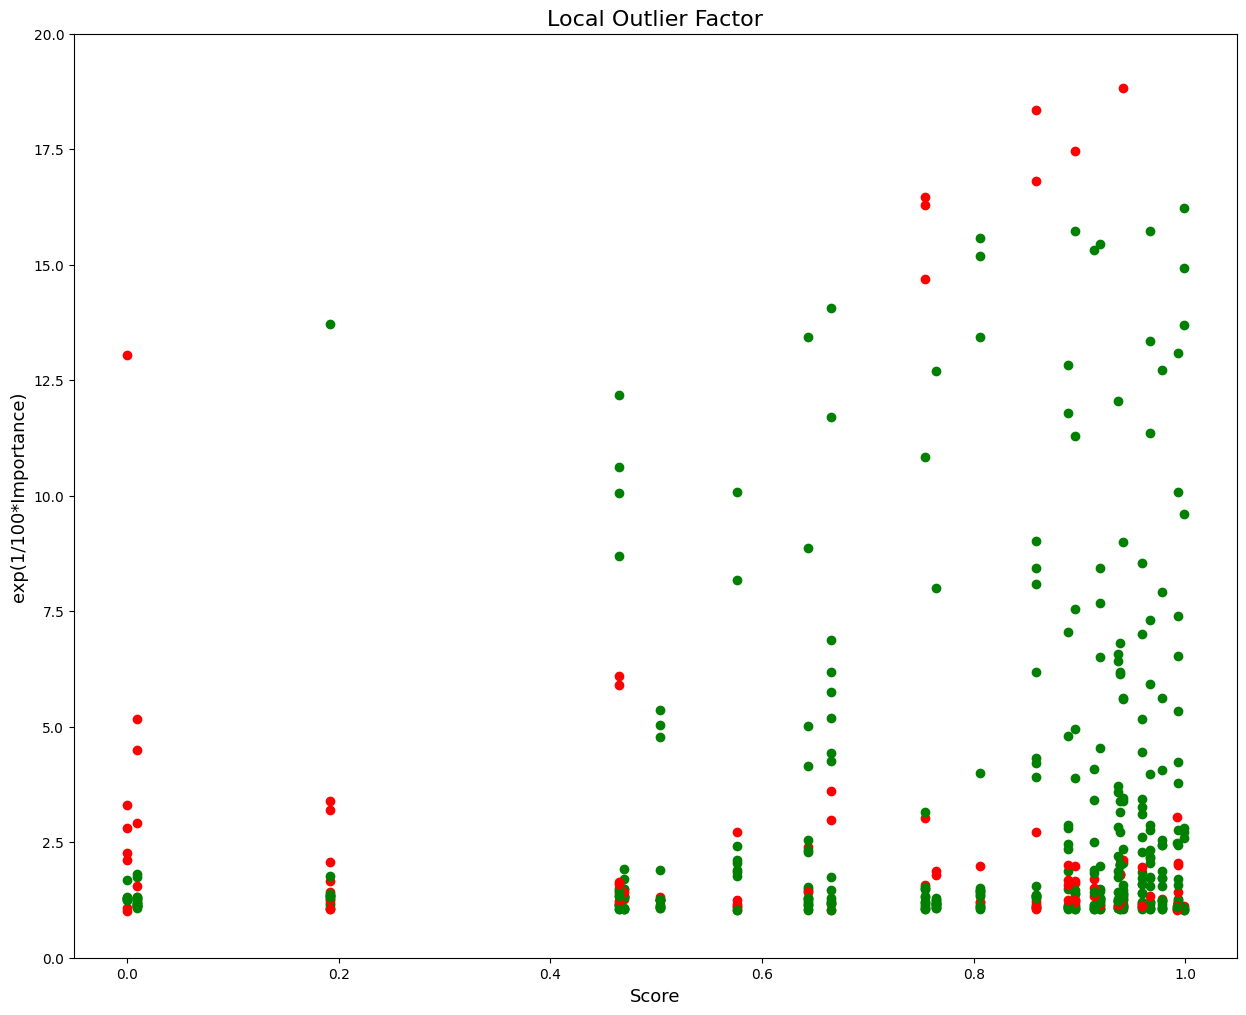

In [22]:
# Identify the points with the highest outlier scores 
outliers_LOF = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_LOF, outliers_LOF, 'Local Outlier Factor', 20)

#### Isolation Forest

In [23]:
### Isolation Forest to detect outliers
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
### The Isolation Forest algorithm is based on the idea that outliers are less frequent and, therefore, easier to isolate.
from sklearn.ensemble import IsolationForest


X_ISO = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]
# X = density_df[['x_scores', 'y_importances']]
# Create an Isolation Forest model
iso_forest = IsolationForest(contamination=0.1) # Adjust contamination based on your dataset
# Fit the model to your data
iso_forest.fit(X_ISO)
# Predict outliers
outliers = iso_forest.predict(X_ISO)
# Calculate the outlier scores for each point 
scores_iso = iso_forest.decision_function(X_ISO) 
##
# density_df['outliers_IF'] = outliers

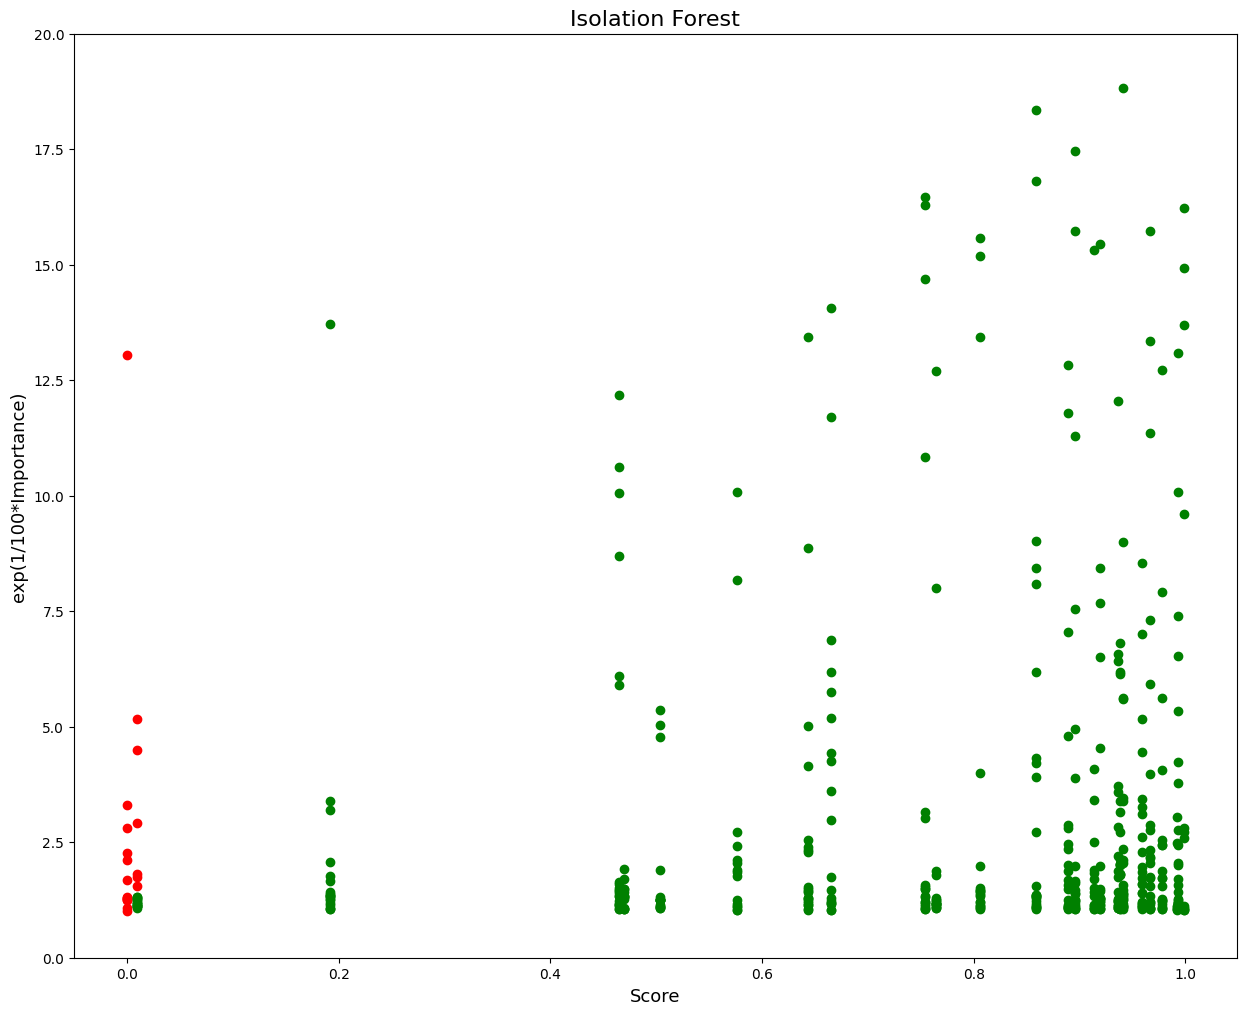

In [24]:
# Identify the points with the highest outlier scores 
outliers_ISO = np.argwhere(scores_iso < np.percentile(scores_iso, 10)) 
# outliers_ISO = np.argwhere(outliers == -1) 
  
plot_outlier_detection(X_ISO, outliers_ISO, 'Isolation Forest', 20)

#### One-Class SVM Outlier

In [25]:
# Import the necessary modules 
from sklearn import svm 

X_SVM = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]

# Define the model and set the nu parameter 
model_svm = svm.OneClassSVM(nu=0.5) 

# Fit the model to the data 
model_svm.fit(X_SVM) 
# y_pred = model_svm.predict(X_SVM) 

# Calculate the outlier scores for each point 
scores_svm = model_svm.decision_function(X_SVM) 

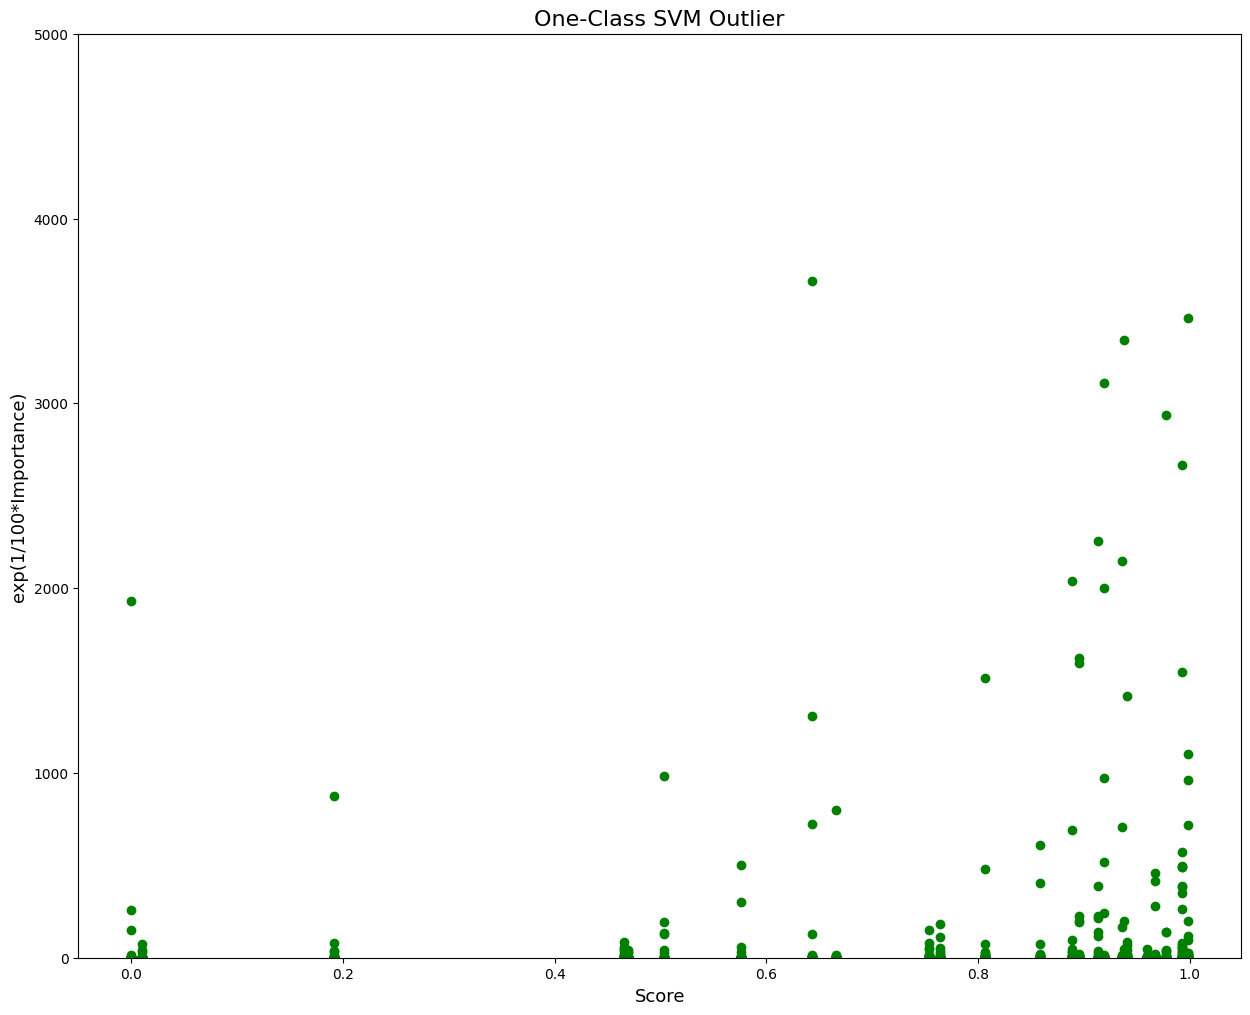

In [26]:
# Identify the points with the highest outlier scores 
outliers_SVM = np.argwhere(scores_svm < np.percentile(scores_svm, 10)) 
# outliers_SVM = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_SVM, outliers_SVM, 'One-Class SVM Outlier', 5000)

#### Elliptic Envelope

In [202]:
# Import the necessary modules 
from sklearn.covariance import EllipticEnvelope 

# X = density_df[density_df['exp_values'] < 100000000000000000][['x_scores', 'exp_values']]
X_EllEnv = density_df[density_df['exp_values'] < math.pow(10, 17)][['x_scores', 'exp_values']]

# Define the model and set the contamination level 
model_EllEnv = EllipticEnvelope(contamination=0.47) 

# Fit the model to the data 
model_EllEnv.fit(X_EllEnv) 
y_pred = model_EllEnv.predict(X_EllEnv) 
# Calculate the outlier scores for each point 
scores_EllEnv = model_EllEnv.decision_function(X_EllEnv)


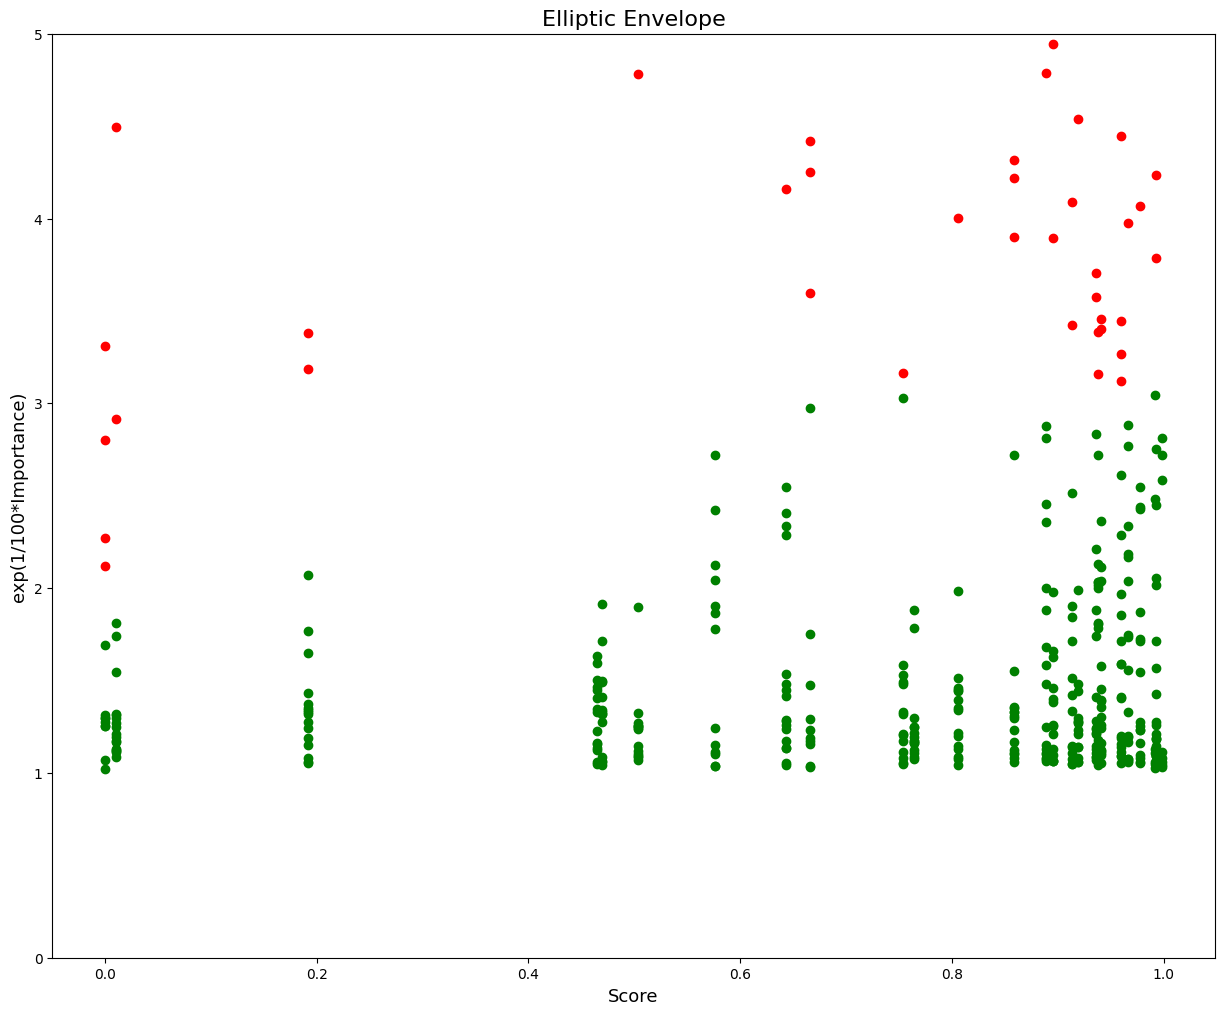

In [203]:
# Identify the points with the highest outlier scores 
# outliers_EllEnv = np.argwhere(scores_EllEnv < np.percentile(scores_EllEnv, 15)) 
outliers_EllEnv = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_EllEnv, outliers_EllEnv, 'Elliptic Envelope', 5)

## TOY EXAMPLE

In [6]:
# !pip3 install gower

In [128]:
### TOY EXAMPLE DATA
### TOY1 ###
# transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9,
#                           0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7,
#                           0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006,
#                           0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79]
# score = [0.95, 0.992, 0.993, 0.995]
# classes_toy = ['C1', 'C2', 'C3', 'C4']
# ## Total 7 features
# feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
### TOY2 ###
# transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9,
#                           0.87, 0.30, 0.91, 0.01, 0.88, 0.0089, 0.009,
#                           0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7,
#                           0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006,
#                           0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79]
# score = [0.95, 0.96, 0.992, 0.993, 0.995]
# classes_toy = ['C1', 'C2', 'C3', 'C4', 'C5']
# ## Total 7 features
# feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
### TOY3 ###
# transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9,
#                           0.87, 0.30, 0.91, 0.01, 0.88, 0.0089, 0.009,
#                           0.98, 0.004, 0.15, 0.72, 0.22, 0.009, 0.02,
#                           0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7, 
#                           0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006,
#                           0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79]
# score = [0.95, 0.96, 0.97, 0.992, 0.993, 0.995]
# classes_toy = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# ## Total 7 features
# feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
### TOY4 ###
transformed_importance = [0.005627, 0.00564, 0.00579, 0.15, 0.21, 0.7, 0.9, 0.93,
                          0.87, 0.30, 0.91, 0.01, 0.88, 0.0089, 0.009, 0.94,
                          0.98, 0.004, 0.15, 0.72, 0.22, 0.009, 0.02, 0.99,
                          0.99, 0.98, 0.89, 0.91, 0.005, 0.99, 0.97, 0.0075, 
                          0.005629, 0.0058, 0.007, 0.992, 0.2, 0.8, 0.7, 0.89,
                          0.005627, 0.25, 0.98, 0.009, 0.85, 0.008, 0.006, 0.98,
                          0.007, 0.0055, 0.0061, 0.14, 0.97, 0.976, 0.79, 0.87]
score = [0.95, 0.96, 0.97, 0.98, 0.992, 0.993, 0.995]
classes_toy = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
## Total 8 features
feats = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [129]:
#### Prepare the data of TOY EXAMPLE
toy_data_df = pd.DataFrame(columns=['transformed_importance', 'score', 'feats'])
toy_data_df['transformed_importance'] = transformed_importance
toy_data_df['score'] = [sc for sc in score for i in range(len(feats))]
toy_data_df['c_name'] = [cl for cl in classes_toy for i in range(len(feats))]
toy_data_df['feats'] = feats*len(score)

In [130]:
# toy_data_df.info()

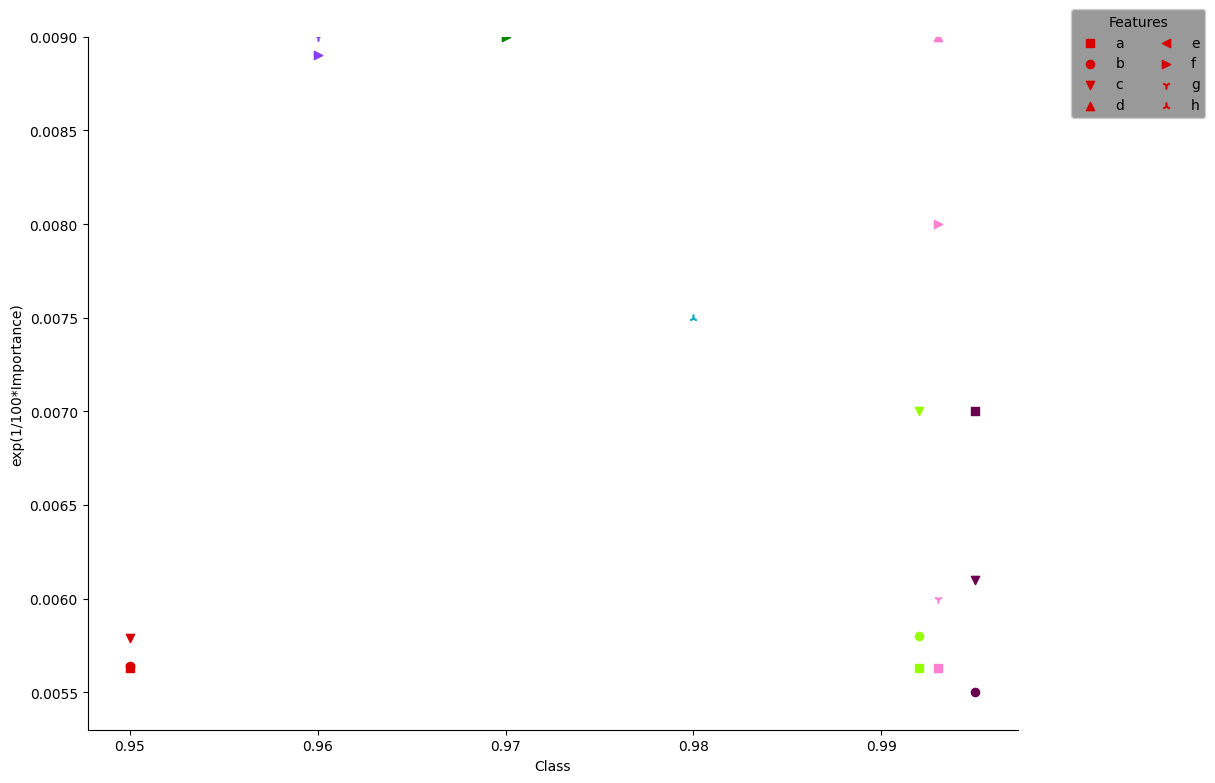

In [131]:
#### CLASS vs IMPORTANCE
## marker: to represent features
marker_lst = [
    ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=7)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feats
class_names = classes_toy
#
fig, ax = plt.subplots(figsize=(12,9))
#
for c in classes_toy:
    for j in np.arange(len(feature_names)):
        data_row = toy_data_df[(toy_data_df['c_name'] == c) & (toy_data_df['feats'] == feature_names[j])]
        #
        ax.scatter(data_row['score'].to_list()[0], data_row['transformed_importance'].to_list()[0], color=color_lst[classes_toy.index(c)], marker=marker_lst[j],
                s=35)

    
## plot feature importance threshold
# ax.hlines(y=25, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(feature_names, bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2, facecolor='gray')
ax.set_xlabel('Class')
ax.set_ylabel('exp(1/100*Importance)')
ax.set_ylim(bottom=0)
ax.set_ylim(0.0053, 0.009)
# ax.set_xlim(0.96, 1)
sns.despine(fig=fig)
plt.show()
plt.close()


### Clustering - TOY EXAMPLE

In [251]:
def plot_cluster_result(cl_method, classes, feature_names, cluster_data, x_column_name, y_column_name):    
    #### CLASS vs IMPORTANCE
    ## marker: to represent features
    marker_lst = [
        ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
        "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
    ]
    ## color: to represent classes
    color_lst = sns.color_palette(cc.glasbey, n_colors=20)
    #
    fig, ax = plt.subplots(figsize=(12,9))
    for c in classes:
        for j in np.arange(len(feature_names)):
            try:
                data_row = cluster_data[(cluster_data['c_name'] == c) & (cluster_data['f_name'] == feature_names[j])]
                #
                if data_row[cl_method].to_list()[0] == -1: ### Outlier
                    ax.scatter(data_row[x_column_name].to_list()[0], data_row[y_column_name].to_list()[0], color='gray', marker=marker_lst[j],
                            s=45)
                else:
                    ax.scatter(data_row[x_column_name].to_list()[0], data_row[y_column_name].to_list()[0], color=color_lst[data_row[cl_method].to_list()[0]], marker=marker_lst[j],
                            s=45)
            except:
                continue

    ax.legend(feature_names, bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2, facecolor='gray')
    ax.set_xlabel('Class')
    ax.set_ylabel('exp(1/100*Importance)')
    ax.set_ylim(bottom=0)
    ax.set_ylim(0.36, 0.5)
    sns.despine(fig=fig)
    plt.show()
    plt.close()

In [114]:
### Gower Distance
# distance_matrix = gower.gower_matrix(toy_data_df[['score', 'feats', 'transformed_importance']])

In [189]:
X_toy = toy_data_df.copy()
for feat in feats:
    X_toy['F'+feat] = np.where(X_toy['feats'] == feat, 1, 0)
#
X_toy = X_toy.drop(['c_name', 'feats'], axis=1)

In [190]:
#### Weighted Euclidean Distance
distance_values = []
weights = []
# The first point
for point1_ind in range(0, len(toy_data_df)):
    dist_array = []
    Point_1 = X_toy.iloc[point1_ind].to_numpy()
    Feat_1 = toy_data_df.iloc[point1_ind]['feats']
    Class_1 = toy_data_df.iloc[point1_ind]['c_name']
    # Get the Transformed Importance value of Point_1 and Find the closest X points in terms of Transformed Importance (same class)
    tr_importance_1 = toy_data_df.iloc[point1_ind]['transformed_importance']
    df_Point_1 = toy_data_df[toy_data_df['c_name'] == Class_1]
    df_Point_1['difference'] = abs(df_Point_1['transformed_importance'] - tr_importance_1)
    closest_points_1 = df_Point_1.sort_values(by='difference')[1:3]['feats'].to_list()
    #
    # The second point
    for point2_ind in range(0, len(toy_data_df)):
        Point_2 = X_toy.iloc[point2_ind].to_numpy()
        Feat_2 = toy_data_df.iloc[point2_ind]['feats']
        Class_2 = toy_data_df.iloc[point2_ind]['c_name']
        # Get the Transformed Importance value of Point_2 and Find the closest X points in terms of Transformed Importance (same class)
        tr_importance_2 = toy_data_df.iloc[point2_ind]['transformed_importance']
        df_Point_2 = toy_data_df[toy_data_df['c_name'] == Class_2]
        df_Point_2['difference'] = abs(df_Point_2['transformed_importance'] - tr_importance_2)
        closest_points_2 = df_Point_2.sort_values(by='difference')[1:3]['feats'].to_list()
        # Find the difference between the closest points of Point_1 and Point_2
        different_points = list(set(closest_points_1).symmetric_difference(set(closest_points_2)))
        #
        ## The DISTANCE between 2 points (EUC)
        euc_distance = math.dist(Point_1, Point_2)
        ##
        #
        # point3_ind = toy_data_df[(toy_data_df['c_name'] == Class_2) & (toy_data_df['feats'] == Feat_1)].index.to_list()[0]
        # point4_ind = toy_data_df[(toy_data_df['c_name'] == Class_1) & (toy_data_df['feats'] == Feat_2)].index.to_list()[0]
        # Point3 = X_toy.iloc[point3_ind].to_numpy()
        # Point4 = X_toy.iloc[point4_ind].to_numpy()
        ##
        ### Dist(F1C1, F2C2) + Dist(F1C1, F1C2) ###
        # weight = math.dist(Point_2, point3)
        #
        ### Dist(F1C1, F2C2) + Dist(F2C2, F1C2) ###
        # weight = math.dist(Point_2, point3)
        #
        ### Distance calculated with the weight = Dist(F1C1, F1C2) + Dist(F2C1, F2C2)
        # weight = math.dist(Point_1, point3) + math.dist(Point_2, Point4)
        #
        ### Distance weighted by un-common features
        # weight = len(different_feats)
        #
        ### Distance weighted by the distance of un-common features(points)
        # if Feat_1 in different_points:
        #     different_points.remove(Feat_1)
        # if Feat_2 in different_points:   
        #     different_points.remove(Feat_2)
        distances_between_neighbors = []
        ## Difference between the same feats in different Class
        for d_feat in different_points:
            p1 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_1) & (toy_data_df['feats'] == d_feat)].index.to_list()[0]].to_numpy() ## FC1
            p2 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_2) & (toy_data_df['feats'] == d_feat)].index.to_list()[0]].to_numpy() ## FC2
            # if Class_1 == 'C3' and class2 == 'C4':
            #     print(p1)
            #     print(p2)
            distances_between_neighbors.append(math.dist(p1,p2))
        if Class_1 == 'C5' and Class_2 == 'C7' and Feat_1 == 'b' and Feat_2 == 'c':
            print(different_points)
        ## Difference between each neighbor 
        # for d_feat_1 in closest_points_1:
        #     for d_feat_2 in closest_points_2:
        #         if (d_feat_2 in different_points) and (d_feat_1 in different_points):
        #             p1 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_1) & (toy_data_df['feats'] == d_feat_1)].index.to_list()[0]].to_numpy() ## FC1
        #             p2 = X_toy.iloc[toy_data_df[(toy_data_df['c_name'] == Class_2) & (toy_data_df['feats'] == d_feat_2)].index.to_list()[0]].to_numpy() ## FC2

        #             distances_between_neighbors.append(math.dist(p1,p2))
        
        #
        if Class_1 == Class_2:                         #C1==C2
            if Feat_1 in different_points:
                different_points.remove(Feat_1)
            if Feat_2 in different_points:   
                different_points.remove(Feat_2)
            weight = len(different_points)
            dist_array.append(euc_distance*weight)
        else:                                           #C1!=C2
            weight = sum(distances_between_neighbors)
            dist_array.append(euc_distance+weight)
            
        # Analysis purposes
        # if Class_1 == 'C2' and Class_2 == 'C4' and Feat_1 == 'b' and Feat_2 == 'a':
        #     print(euc_distance)
        #     print(weight)
        #     print(euc_distance*weight)
        #     print(different_points)

    distance_values.append(dist_array)
# distance_values

['c', 'b']


#### Clustering approaches

In [191]:
# Initialize the DBSCAN clustering model
dbscan = DBSCAN(eps=0.002, min_samples=2, metric='precomputed')
# Fit the model to the data
dbscan.fit(distance_values)
 
# Get the cluster labels
labels = dbscan.labels_
toy_data_df['DBSCAN'] = labels

labels

array([ 0,  0,  0,  1,  1,  2,  2,  2,  3,  4,  3,  4,  3,  4,  4,  3,  5,
        6,  7,  5,  7,  6,  6,  5,  8,  8,  9,  9, 10,  8, -1, 10, 11, 11,
       11, 12, 11, 12, 12, 12, 13, -1, 14, 13, 14, 13, 13, 14, 15, 15, 15,
       15, 16, 16, 16, 16])

In [134]:
# Initialize the OPTICS clustering model
optics = OPTICS(min_samples=2, metric='precomputed')
# Fit the model to the data
optics.fit(distance_values)
 
# Get the cluster labels
labels = optics.labels_
toy_data_df['OPTICS'] = labels

labels

array([ 0,  0,  0,  8,  8, 12, 12, 12,  5,  9,  5,  9,  5,  9,  9,  5,  7,
       13,  3,  7,  3, 13, 13,  7, 16, 16, 15, 15,  6, 16, 16,  6,  1,  1,
        1, 11,  1, 11, 11, 11, 10, -1,  4, 10,  4, 10, 10,  4,  2,  2,  2,
        2, 14, 14, 14, 14])

In [135]:
# Initialize the HDBSCAN clustering model
hdbscan = HDBSCAN(min_cluster_size=2, metric='precomputed')
 
# Fit the model to the data
optics.fit(distance_values)
 
# Get the cluster labels
labels = optics.labels_
toy_data_df['HDBSCAN'] = labels

labels

array([ 0,  0,  0,  8,  8, 12, 12, 12,  5,  9,  5,  9,  5,  9,  9,  5,  7,
       13,  3,  7,  3, 13, 13,  7, 16, 16, 15, 15,  6, 16, 16,  6,  1,  1,
        1, 11,  1, 11, 11, 11, 10, -1,  4, 10,  4, 10, 10,  4,  2,  2,  2,
        2, 14, 14, 14, 14])

In [138]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=7, linkage='average', affinity='precomputed')
#
clusters_average = model_average.fit_predict(distance_values)
#
toy_data_df['AGGLOMERATIVE'] = clusters_average
clusters_average

array([4, 4, 4, 0, 0, 2, 2, 2, 0, 5, 0, 5, 0, 5, 5, 0, 6, 5, 1, 6, 1, 5,
       5, 6, 3, 3, 1, 1, 0, 3, 3, 0, 4, 4, 4, 2, 4, 2, 2, 2, 5, 5, 0, 5,
       0, 5, 5, 0, 4, 4, 4, 4, 2, 2, 2, 2])

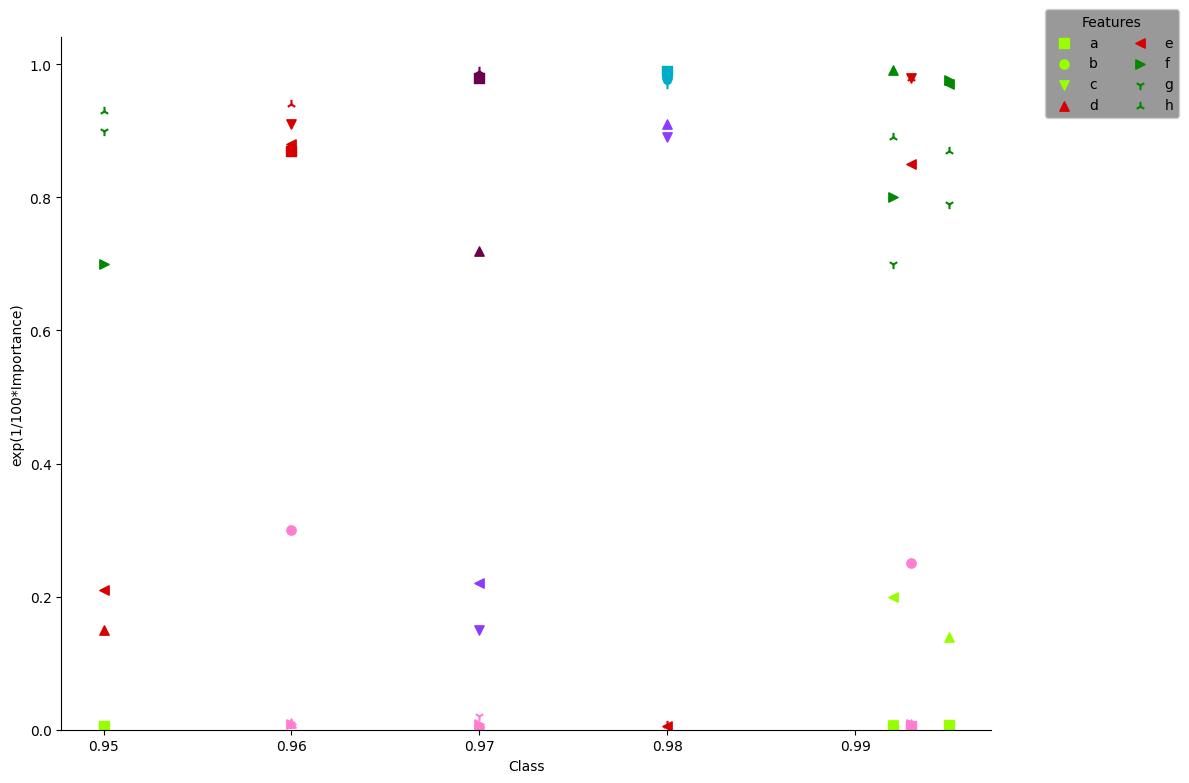

In [139]:
plot_cluster_result('AGGLOMERATIVE', classes_toy, feats, toy_data_df, 'score', 'transformed_importance')

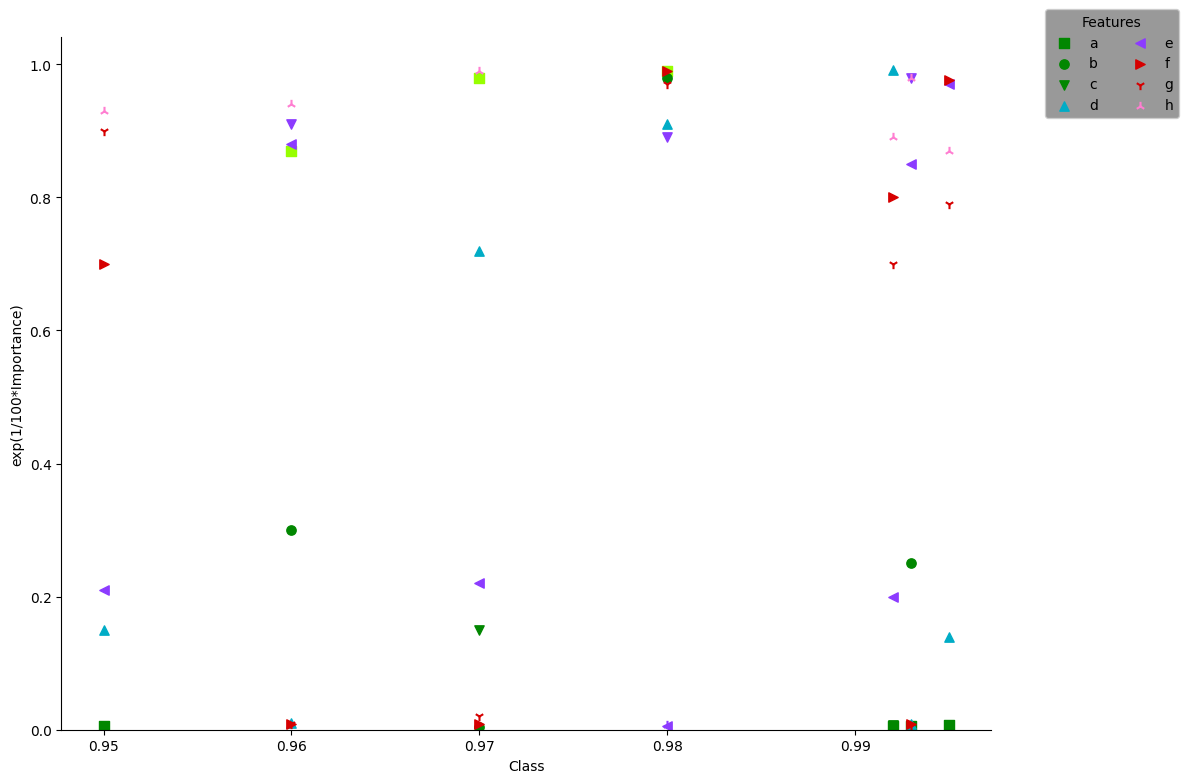

In [131]:
plot_cluster_result('AGGLOMERATIVE', classes_toy, feats)

## CLUSTERING
#### To be visited later. I will continue with a toy example.

In [231]:
filtered_density_df = density_df[density_df['exp_values'] < math.pow(10, 17)]

In [232]:
X_EllEnv = filtered_density_df[['x_scores', 'exp_values']]

# Define the model and set the contamination level 
model_EllEnv = EllipticEnvelope(contamination=0.50) 

# Fit the model to the data 
model_EllEnv.fit(X_EllEnv) 
y_pred = model_EllEnv.predict(X_EllEnv) 
# Calculate the outlier scores for each point 
scores_EllEnv = model_EllEnv.decision_function(X_EllEnv)

filtered_density_df['outliers_EllEnv'] = y_pred

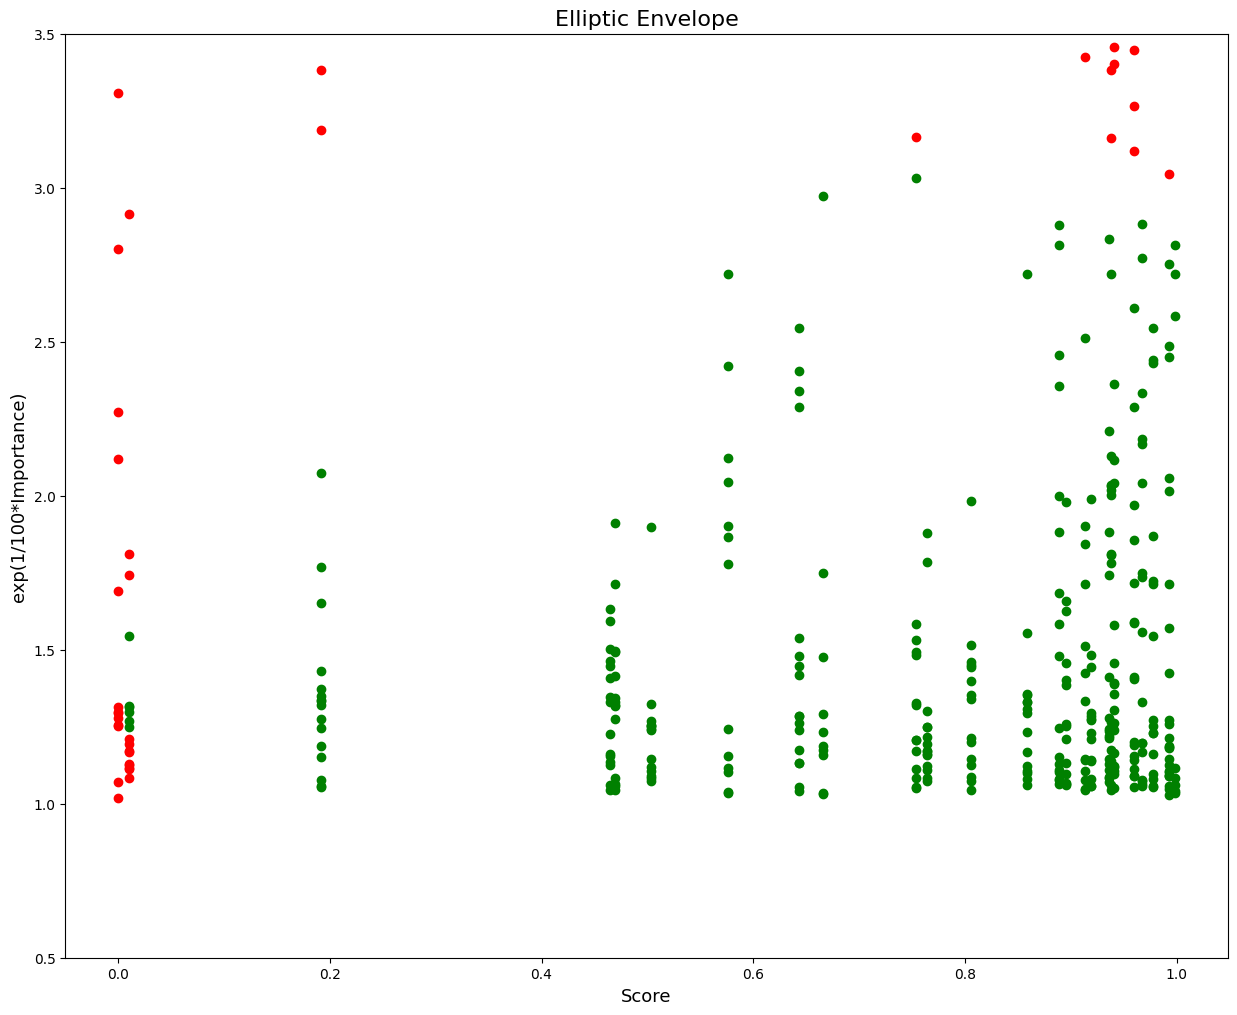

In [233]:
# Identify the points with the highest outlier scores 
# outliers_EllEnv = np.argwhere(scores_EllEnv < np.percentile(scores_EllEnv, 15)) 
outliers_EllEnv = np.argwhere(y_pred == -1) 

plot_outlier_detection(X_EllEnv, outliers_EllEnv, 'Elliptic Envelope', 3.5)

In [234]:
cluster_data = filtered_density_df[filtered_density_df['outliers_EllEnv'] == 1]
cluster_data = cluster_data[['c_name', 'f_name', 'Feature', 'exp_values', 'x_scores']]

In [149]:
cluster_data

,c_name,f_name,Feature,exp_values,x_scores
0,Light Bulbs LiFX Smart Bulb,ip.len,0,1.115817,0.998366
1,Light Bulbs LiFX Smart Bulb,ip.ttl,1,1.041925,0.998366
8,Light Bulbs LiFX Smart Bulb,ip.proto,8,2.813918,0.998366
9,Light Bulbs LiFX Smart Bulb,srcport,9,1.082076,0.998366
10,Light Bulbs LiFX Smart Bulb,dstport,10,1.033912,0.998366
...,...,...,...,...,...
791,Blipcare Blood Pressure meter,Max Packet Length,16,1.316499,0.010000
797,Blipcare Blood Pressure meter,Flow IAT Max,22,1.299421,0.010000
799,Blipcare Blood Pressure meter,Flow Duration,24,1.267528,0.010000
802,Blipcare Blood Pressure meter,PSH Flag Count,27,1.312686,0.010000


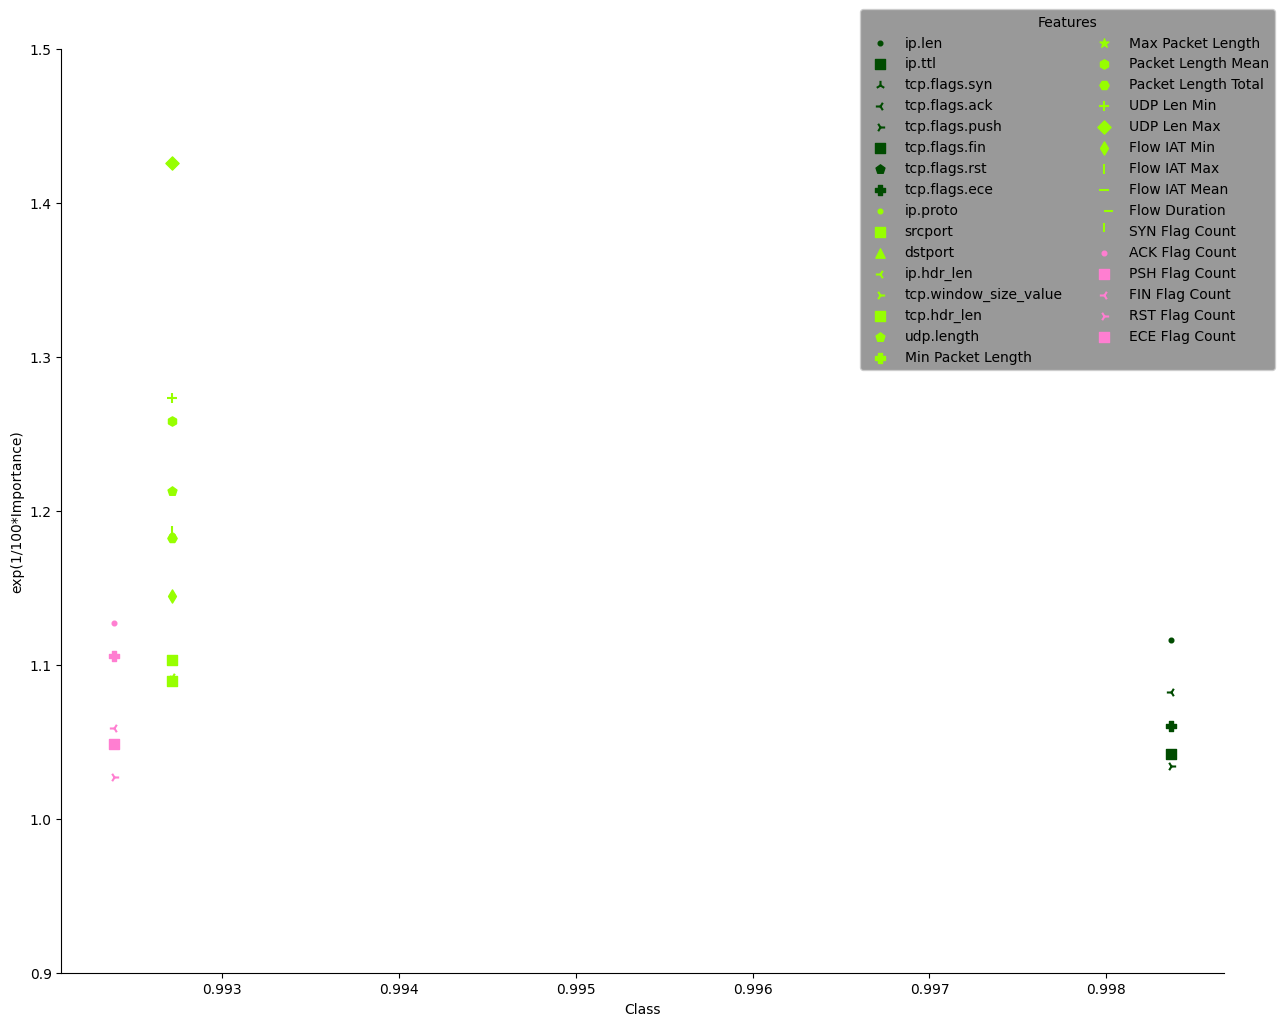

In [235]:
#### CLASS vs IMPORTANCE
## marker: to represent features
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feature_names
class_names = classes_ordered
len_class_names = len(class_names)
#
fig, ax = plt.subplots(figsize=(15,12))
# for j in np.arange(len(feature_names)):
#     ax.scatter(density_df[density_df['f_name']==feature_names[j]]['x_scores'].to_list(),
#                density_df[density_df['f_name']==feature_names[j]]['exp_values'].to_list(), color=color_lst, marker=marker_lst[j],
#                s=25, label=feature_names[j])
    # if j==15:
    #     break
for c in classes_ordered[:3]:
    for j in np.arange(len(feature_names)):
        data_row = cluster_data[(cluster_data['c_name'] == c) & (cluster_data['f_name'] == feature_names[j])]
        try:
            ax.scatter(data_row['x_scores'].to_list()[0], data_row['exp_values'].to_list()[0], color=color_lst[classes.index(c)], marker=marker_lst[j],
                    s=45)
        except:
            continue
    # break
    
## plot feature importance threshold
# ax.hlines(y=25, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(feature_names, bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2, facecolor='gray')
# ax.set_xticks(Class_2cores_ordered)
# ax.set_xticklabels(feature_names, rotation=90, fontsize = 10)
ax.set_xlabel('Class')
ax.set_ylabel('exp(1/100*Importance)')
ax.set_ylim(bottom=0)
ax.set_ylim(0.9, 1.5)
# ax.set_xlim(0.96, 1)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


In [236]:
cluster_data = cluster_data[cluster_data['x_scores'] > 0.99]

In [237]:
for f_ind in range(0,len(feats_all)):
    cluster_data[feature_names[f_ind]] = np.where(cluster_data['Feature'] == f_ind, 1, 0)

In [238]:
cluster_data = cluster_data.reset_index(drop=True)

In [239]:
X = cluster_data.drop(['c_name', 'f_name', 'Feature'], axis=1)

In [240]:
# copy the data 
X_scaled = X.copy() 
  
# apply normalization techniques on Column 1 
column = 'exp_values'
X_scaled[column] = X_scaled[column]/X_scaled[column].abs().max() 
  
# view normalized data 
# display(X_scaled) 

In [252]:
def get_distance_matrix(X, cluster_data):
    #### Weighted Euclidean Distance
    distance_values = []
    weights = []
    euc_distances = []
    # The first point
    for point1_ind in range(0, len(cluster_data)):
        dist_array = []
        Point_1 = X.iloc[point1_ind].to_numpy()
        Feat_1 = cluster_data.iloc[point1_ind]['f_name']
        Class_1 = cluster_data.iloc[point1_ind]['c_name']
        # Get the Transformed Importance value of Point_1 and Find the closest X points in terms of Transformed Importance (same class)
        tr_importance_1 = cluster_data.iloc[point1_ind]['exp_values']
        df_Point_1 = cluster_data[cluster_data['c_name'] == Class_1]
        df_Point_1['difference'] = abs(df_Point_1['exp_values'] - tr_importance_1)
        closest_points_1 = df_Point_1.sort_values(by='difference')[1:5]['f_name'].to_list()
        #
        # The second point
        for point2_ind in range(0, len(cluster_data)):
            Point_2 = X.iloc[point2_ind].to_numpy()
            Feat_2 = cluster_data.iloc[point2_ind]['f_name']
            Class_2 = cluster_data.iloc[point2_ind]['c_name']
            # Get the Transformed Importance value of Point_2 and Find the closest X points in terms of Transformed Importance (same class)
            tr_importance_2 = cluster_data.iloc[point2_ind]['exp_values']
            df_Point_2 = cluster_data[cluster_data['c_name'] == Class_2]
            df_Point_2['difference'] = abs(df_Point_2['exp_values'] - tr_importance_2)
            closest_points_2 = df_Point_2.sort_values(by='difference')[1:5]['f_name'].to_list()
            # Find the difference between the closest points of Point_1 and Point_2
            different_points = list(set(closest_points_1).symmetric_difference(set(closest_points_2)))
            #
            ## The DISTANCE between 2 points (EUC)
            euc_distance = math.dist(Point_1, Point_2)
            euc_distances.append(euc_distance)
            ##
            ### Distance weighted by the distance of un-common features(points)
            if Feat_1 in different_points:
                different_points.remove(Feat_1)
            if Feat_2 in different_points:   
                different_points.remove(Feat_2)
            distances_between_neighbors = []
            ## Difference between the same feats in different Class
            # print(different_points)
            for d_feat in different_points:
                try:
                    p1= X.iloc[cluster_data[(cluster_data['c_name'] == Class_1) & (cluster_data['f_name'] == d_feat)].index.to_list()[0]].to_numpy() ## FC1
                    p2 = X.iloc[cluster_data[(cluster_data['c_name'] == Class_2) & (cluster_data['f_name'] == d_feat)].index.to_list()[0]].to_numpy() ## FC2
                    # if Class_1 == 'Smart Things' and Class_2 == 'Light Bulbs LiFX Smart Bulb' and Feat_1 == 'ip.ttl' and Feat_2 == 'ip.ttl':
                    #     print(p1)
                    #     print(p2)
                    distances_between_neighbors.append(math.dist(p1,p2))
                except:
                    distances_between_neighbors.append(10)

            if Class_1 == Class_2:                         #C1==C2
                weight = len(different_points) 
                dist_array.append(euc_distance*weight)
            else:                                           #C1!=C2
                weight = sum(distances_between_neighbors)
                dist_array.append(euc_distance+weight)
            

        distance_values.append(dist_array)
    print(max(euc_distances))
    return distance_values
# distance_values

In [253]:
distance_values = get_distance_matrix(X_scaled, cluster_data)

1.5502870902658947


In [254]:
# Initialize the Agglomerative clustering model
model_average = AgglomerativeClustering(n_clusters=4, linkage='average', affinity='precomputed')
#
clusters_average = model_average.fit_predict(distance_values)
#
cluster_data['AGGLOMERATIVE'] = clusters_average
clusters_average

array([3, 3, 2, 3, 3, 2, 2, 3, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 3, 3, 3, 3, 3, 3])

In [255]:
# apply normalization techniques on Column 1 
column = 'exp_values'
cluster_data[column] = cluster_data[column]/cluster_data[column].abs().max() 

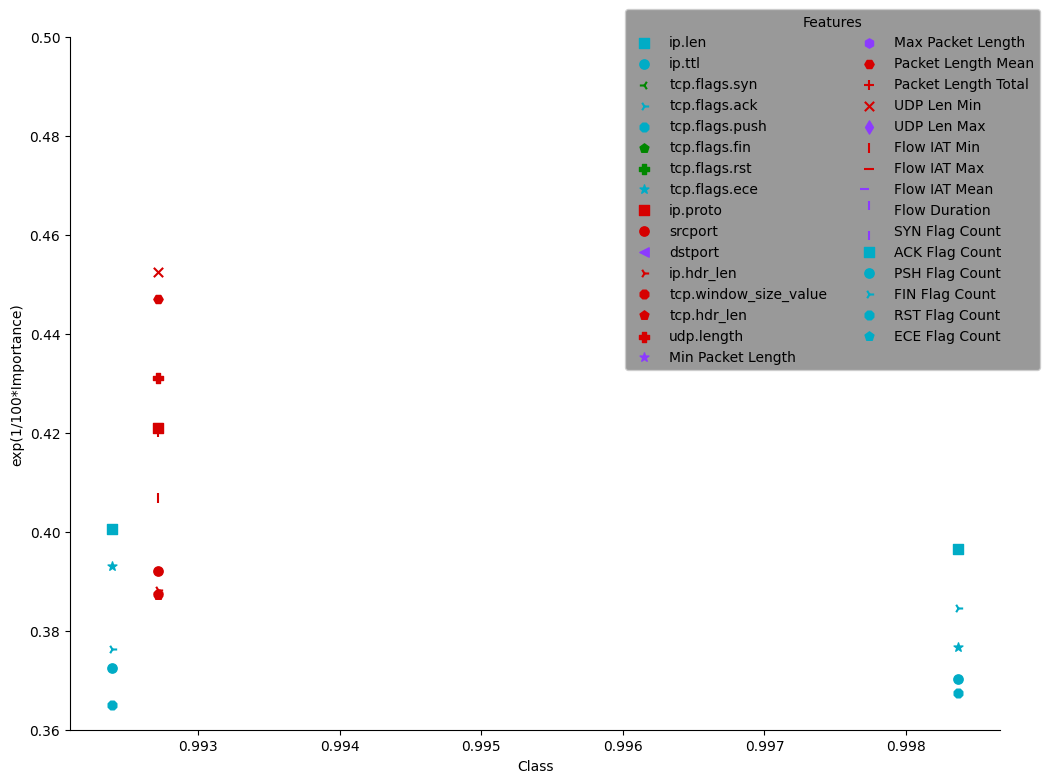

In [256]:
plot_cluster_result('AGGLOMERATIVE', classes_ordered[:3], feature_names, cluster_data, 'x_scores', 'exp_values')